In [263]:
import math
import matplotlib.pyplot as plt
# calculus
import sympy as sym
import random
import numpy as np

## Capture probability function

In [293]:
def P_cap(Px, Py, CR):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = math.sqrt(Py * Pr / Px)
    slope_2 = math.sqrt(Py / (Px * Pr))

    if slope_1 > 1 and slope_2 < 1:
        result = (1 / math.sqrt(Pr * Py / Px) / 2) + (math.sqrt(Py / (Pr * Px)) / 2)
    elif slope_1 > 1 and slope_2 >= 1:
        result = 1 - (1 / math.sqrt(Py / (Pr * Px)) - 1 / math.sqrt(Pr * Py / Px)) / 2
    elif slope_1 <= 1 and slope_2 < 1:
        result = 1 - (math.sqrt(Pr * Py / Px) - math.sqrt(Py / (Pr * Px))) / 2
    return result

In [338]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]

    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            
        #/** Calculate capture probability for slot i */
        capture_prob = 0
        if M[i] > 0:
            for n1 in range(1, step+1):
                for n2 in range(1, step+1):
                    # sta_ratio is M_i[n] / M_i
                    sta_ratio_1 = 0
                    if (n1 == step):
                        for k in range(n1, Lmax+1):
                            sta_ratio_1 += M_i[i][k] / M[i]
                    else:
                        sta_ratio_1 = M_i[i][n1] / M[i]

                    sta_ratio_2 = 0
                    if (n2 == step):
                        for k in range(n2, Lmax+1):
                            sta_ratio_2 += M_i[i][k] / M[i]
                    else:
                        sta_ratio_2 = M_i[i][n2] / M[i]
                    # P is the power of two station
                    P1 = 2 ** (n1 - 1)
                    P2 = 2 ** (n2 - 1)

                    capture_prob += P_cap(P1, P2, CR) * sta_ratio_1 * sta_ratio_2
        #/** statistics */  
        for n in range (1, Lmax+1):
            M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * M_i[i][n] * (M[i]-1) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]


        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
    
    return Imax,success_probability,access_delay, utilization, through_put  # ,sta*success_probability

# CR=1.5

In [329]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200
# sta_max = 500
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

# for r in R:
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=1.5, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U

1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9703411516950569
0.0 0.02965884830494311
0.0 0.0
0.9703411516950569 0.0
0.9703411516950569 0.0
0.02965884830494311 0.0
0.02965884830494311 0.0
0.0 0.0
0.0 0.9703411516950569
0.0 0.02965884830494311
0.0 0.0
0.0 0.0
0.0 0.9703411516950569
0.0 0.02965884830494311
0.0 0.0
0.9703411516950569 0.0
0.9703411516950569 0.0
0.02965884830494311 0.0
0.02965884830494311 0.0
0.0 0.0
0.0 0.970341151

0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0


0.0 0.9481598861551003
0.0 0.05184011384489972
0.0 0.0
0.9481598861551003 0.0
0.9481598861551003 0.0
0.05184011384489972 0.0
0.05184011384489972 0.0
0.0 0.0
0.0 0.9481598861551003
0.0 0.05184011384489972
0.0 0.0
0.0 0.0
0.0 0.9481598861551003
0.0 0.05184011384489972
0.0 0.0
0.9481598861551003 0.0
0.9481598861551003 0.0
0.05184011384489972 0.0
0.05184011384489972 0.0
0.0 0.0
0.0 0.9481598861551003
0.0 0.05184011384489972
0.0 0.0
0.0 0.0
0.0 0.9481598861551003
0.0 0.05184011384489972
0.0 0.0
0.9481598861551003 0.0
0.9481598861551003 0.0
0.05184011384489972 0.0
0.05184011384489972 0.0
0.0 0.0
0.0 0.9481598861551003
0.0 0.05184011384489972
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9813570244859595
0.0 0.018642975514040535
0.0 0.0
0.0 0.0
0.0 0.9813570244859595
0.0 0.018642975514040535
0.9813570244859595 0.0
0.9813570244859595 0.0
0.018642975514040535 0.0
0.018642975514040535 0.0
0.0 0.0
0.0 0.0
0.0 0.9813570244859595
0.0 0.018642975514040535
0.0 0.0
0.0 0.0
0.0 0.9813570244859595
0.0 0.018642975514040

0.9215621335760144 0.0
0.9215621335760144 0.0
0.07843786642398556 0.0
0.07843786642398556 0.0
0.0 0.0
0.0 0.0
0.0 0.9215621335760144
0.0 0.07843786642398556
0.0 0.0
0.0 0.0
0.0 0.9215621335760144
0.0 0.07843786642398556
0.9215621335760144 0.0
0.9215621335760144 0.0
0.07843786642398556 0.0
0.07843786642398556 0.0
0.0 0.0
0.0 0.0
0.0 0.7383010510934434
0.0 0.26169894890655654
0.0 0.0
0.0 0.0
0.0 0.7383010510934434
0.0 0.26169894890655654
0.7383010510934434 0.0
0.7383010510934434 0.0
0.26169894890655654 0.0
0.26169894890655654 0.0
0.0 0.0
0.0 0.0
0.0 0.7383010510934434
0.0 0.26169894890655654
0.0 0.0
0.0 0.0
0.0 0.7383010510934434
0.0 0.26169894890655654
0.7383010510934434 0.0
0.7383010510934434 0.0
0.26169894890655654 0.0
0.26169894890655654 0.0
0.0 0.0
0.0 0.0
0.0 0.7383010510934434
0.0 0.26169894890655654
0.0 0.0
0.0 0.0
0.0 0.7383010510934434
0.0 0.26169894890655654
0.7383010510934434 0.0
0.7383010510934434 0.0
0.26169894890655654 0.0
0.26169894890655654 0.0
0.0 0.0
0.0 0.0
0.0 0.7383

0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0


1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0


0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.8791495741091138
0.0 0.12085042589088629
0.0 0.0
0.8791495741091138 0.0
0.8791495741091138 0.0
0.12085042589088629 0.0
0.12085042589088629 0.0
0.0 0.0
0.0 0.8791495741091138
0.0 0.12085042589088629
0.0 0.0
0.0 0.0
0.0 0.8791495741091138
0.0 0.12085042589088629
0.0 0.0
0.8791495741091138 0.0
0.8791495741091138 0.0
0.12085042589088629 0.0
0.12085042589088629 0.0
0.0 0.0
0.0 0.8791495741091138
0.0 0.12085042589088629
0.0 0.0
0.0 0.0
0.0 0.8791495741091138
0.0 0.12085042589088629
0.0 0.0
0.8791495741091138 0.0
0.8791495741091138 0.0
0.12085042589088629 0.0
0.12085042589088629 0.0
0.0 0.0
0.0 0.8791495741091138
0.0 0.12085042589088629
0.0 0.0
0.0 0.0
0.0 0.8791495741091138
0.0 0.12085042589088629
0.0 0.0
0.8791495741091138 0.0
0.8791495741091138 0.0
0.1208504258908

0.0 0.0
0.0 0.9298147807015817
0.0 0.07018521929841819
0.9298147807015817 0.0
0.9298147807015817 0.0
0.07018521929841819 0.0
0.07018521929841819 0.0
0.0 0.0
0.0 0.0
0.0 0.8607023771114551
0.0 0.13929762288854475
0.0 0.0
0.0 0.0
0.0 0.8607023771114551
0.0 0.13929762288854475
0.8607023771114551 0.0
0.8607023771114551 0.0
0.13929762288854475 0.0
0.13929762288854475 0.0
0.0 0.0
0.0 0.0
0.0 0.8607023771114551
0.0 0.13929762288854475
0.0 0.0
0.0 0.0
0.0 0.8607023771114551
0.0 0.13929762288854475
0.8607023771114551 0.0
0.8607023771114551 0.0
0.13929762288854475 0.0
0.13929762288854475 0.0
0.0 0.0
0.0 0.0
0.0 0.8607023771114551
0.0 0.13929762288854475
0.0 0.0
0.0 0.0
0.0 0.8607023771114551
0.0 0.13929762288854475
0.8607023771114551 0.0
0.8607023771114551 0.0
0.13929762288854475 0.0
0.13929762288854475 0.0
0.0 0.0
0.0 0.0
0.0 0.8607023771114551
0.0 0.13929762288854475
0.0 0.0
0.0 0.0
0.0 0.8607023771114551
0.0 0.13929762288854475
0.8607023771114551 0.0
0.8607023771114551 0.0
0.13929762288854475

0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.

0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0


0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.8112502008943971
0.0 0.1887497991056028
0.0 0.0
0.8112502008943971 0.0
0.8112502008943971 0.0
0.1887497991056028 0.0
0.1887497991056028 0.0
0.0 0.0
0.0 0.8112502008943971
0.0 0.1887497991056028
0.0 0.0
0.0 0.0
0.0 0.8112502008943971
0.0 0.1887497991056028
0.0 0.0
0.8112502008943971 0.0
0.8112502008943971 0.0
0.1887497991056028 0.0
0.1887497991056028 0.0
0.0 0.

0.0 0.8806896026006013
0.0 0.11931039739939876
0.0 0.0
0.0 0.0
0.0 0.8806896026006013
0.0 0.11931039739939876
0.8806896026006013 0.0
0.8806896026006013 0.0
0.11931039739939876 0.0
0.11931039739939876 0.0
0.0 0.0
0.0 0.0
0.0 0.8806896026006013
0.0 0.11931039739939876
0.0 0.0
0.0 0.0
0.0 0.8806896026006013
0.0 0.11931039739939876
0.8806896026006013 0.0
0.8806896026006013 0.0
0.11931039739939876 0.0
0.11931039739939876 0.0
0.0 0.0
0.0 0.0
0.0 0.8806896026006013
0.0 0.11931039739939876
0.0 0.0
0.0 0.0
0.0 0.8806896026006013
0.0 0.11931039739939876
0.8806896026006013 0.0
0.8806896026006013 0.0
0.11931039739939876 0.0
0.11931039739939876 0.0
0.0 0.0
0.0 0.0
0.0 0.8806896026006013
0.0 0.11931039739939876
0.0 0.0
0.0 0.0
0.0 0.8806896026006013
0.0 0.11931039739939876
0.8806896026006013 0.0
0.8806896026006013 0.0
0.11931039739939876 0.0
0.11931039739939876 0.0
0.0 0.0
0.0 0.0
0.0 0.8806896026006013
0.0 0.11931039739939876
0.0 0.0
0.0 0.0
0.0 0.8806896026006013
0.0 0.11931039739939876
0.88068960

0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0


0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.10620694484627774 0.0
0.0 0.0
0.0 0.0
0.0 0.8937930551537222
0.0 0.10620694484627774
0.0 0.0
0.0 0.0
0.0 0.8937930551537222
0.0 0.10620694484627774
0.8937930551537222 0.0
0.8937930551537222 0.0
0.10620694484627774 0.0
0.10620694484627774 0.0
0.0 0.0
0.0 0.0
0.0 0.8937930551537222
0.0 0.10620694484627774
0.0 0.0
0.0 0.0
0.0 0.8937930551537222
0.0 0.10620694484627774
0.8937930551537222 0.0
0.8937930551537222 0.0
0.10620694484627774 0.0
0.10620694484627774 0.0
0.0 0.0
0.0 0.0
0.0 0.8937930551537222
0.0 0.10620694484627774
0.0 0.0
0.0 0.0
0.0 0.8937930551537222
0.0 0.10620694484627774
0.8937930551537222 0.0
0.8937930551537222 0.0
0.10620694484627774 0.0
0.10620694484627774 0.0
0.0 0.0
0.0 0.0
0.0 0.8937930551537222
0.0 0.10620694484627774
0.0 0.0
0.0 0.0
0.0 0.8937930551537222
0.0 0.10620694484627774
0.8937930551537222 0.0
0.8937930551537222 0.0
0.10620694484627774 0.0
0.10620694484627774 0.0
0.0 0.0
0.0 0.0
0.0 0.8278546161612828
0.0 0.17214538383871741
0.0 0.0
0.0 0.0
0.0 0.82785461616

0.0 0.3233308129069105
0.0 0.6766691870930894
0.3233308129069105 0.0
0.3233308129069105 0.0
0.6766691870930894 0.0
0.6766691870930894 0.0
0.0 0.0
0.0 0.0
0.0 0.3233308129069105
0.0 0.6766691870930894
0.0 0.0
0.0 0.0
0.0 0.3233308129069105
0.0 0.6766691870930894
0.3233308129069105 0.0
0.3233308129069105 0.0
0.6766691870930894 0.0
0.6766691870930894 0.0
0.0 0.0
0.0 0.0
0.0 0.3233308129069105
0.0 0.6766691870930894
0.0 0.0
0.0 0.0
0.0 0.3233308129069105
0.0 0.6766691870930894
0.3233308129069105 0.0
0.3233308129069105 0.0
0.6766691870930894 0.0
0.6766691870930894 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.

0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0


0.7219373426078665 0.0
0.2780626573921336 0.0
0.2780626573921336 0.0
0.0 0.0
0.0 0.7219373426078665
0.0 0.2780626573921336
0.0 0.0
0.0 0.0
0.0 0.7219373426078665
0.0 0.2780626573921336
0.0 0.0
0.7219373426078665 0.0
0.7219373426078665 0.0
0.2780626573921336 0.0
0.2780626573921336 0.0
0.0 0.0
0.0 0.7219373426078665
0.0 0.2780626573921336
0.0 0.0
0.0 0.0
0.0 0.7219373426078665
0.0 0.2780626573921336
0.0 0.0
0.7219373426078665 0.0
0.7219373426078665 0.0
0.2780626573921336 0.0
0.2780626573921336 0.0
0.0 0.0
0.0 0.7219373426078665
0.0 0.2780626573921336
0.0 0.0
0.0 0.0
0.0 0.7219373426078665
0.0 0.2780626573921336
0.0 0.0
0.7219373426078665 0.0
0.7219373426078665 0.0
0.2780626573921336 0.0
0.2780626573921336 0.0
0.0 0.0
0.0 0.7219373426078665
0.0 0.2780626573921336
0.0 0.0
0.0 0.0
0.0 0.7219373426078665
0.0 0.2780626573921336
0.0 0.0
0.7219373426078665 0.0
0.7219373426078665 0.0
0.2780626573921336 0.0
0.2780626573921336 0.0
0.0 0.0
0.0 0.7219373426078665
0.0 0.2780626573921336
0.0 0.0
0.0 0

0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.7178051188531247
0.0 0.2821948811468753
0.0 0.0
0.7178051188531247 0.0
0.7178051188531247 0.0
0.2821948811468753 0.0
0.2821948811468753 0.0
0.0 0.0
0.0 0.7178051188531247
0.0 0.2821948811468753
0.0 0.0
0.0 0.0
0.0 0.7178051188531247
0.0 0.2821948811468753
0.0 0.0
0.7178051188531247 0.0
0.7178051188531247 0.0
0.2821948811468753 0.0
0.2821948811468753 0.0
0.0 0.0
0.0 0.7178051188531247
0.0 0.2821948811468753
0.0 0.0
0.0 0.0
0.0 0.7178051188531247
0.0 0.2821948811468753
0.0 0.0
0.7178051188531247 0.0
0.7178051188531247 0.0
0.2821948811468753 0.0
0.2821948811468753 0.0
0.0 0.0
0.0 0.7178051188531247
0.0 0.2821948811468753
0.0 0.0
0.0 0.0
0.0 0.7178051188531247
0.0 0.2821948811468753
0.0 0.0
0.7178051188531247 0.0
0.7178051188531247 

0.0 0.0
0.0 0.7677690049086161
0.0 0.232230995091384
0.0 0.0
0.0 0.0
0.0 0.7677690049086161
0.0 0.232230995091384
0.7677690049086161 0.0
0.7677690049086161 0.0
0.232230995091384 0.0
0.232230995091384 0.0
0.0 0.0
0.0 0.0
0.0 0.5772775078663384
0.0 0.42272249213366175
0.0 0.0
0.0 0.0
0.0 0.5772775078663384
0.0 0.42272249213366175
0.5772775078663384 0.0
0.5772775078663384 0.0
0.42272249213366175 0.0
0.42272249213366175 0.0
0.0 0.0
0.0 0.0
0.0 0.5772775078663384
0.0 0.42272249213366175
0.0 0.0
0.0 0.0
0.0 0.5772775078663384
0.0 0.42272249213366175
0.5772775078663384 0.0
0.5772775078663384 0.0
0.42272249213366175 0.0
0.42272249213366175 0.0
0.0 0.0
0.0 0.0
0.0 0.5772775078663384
0.0 0.42272249213366175
0.0 0.0
0.0 0.0
0.0 0.5772775078663384
0.0 0.42272249213366175
0.5772775078663384 0.0
0.5772775078663384 0.0
0.42272249213366175 0.0
0.42272249213366175 0.0
0.0 0.0
0.0 0.0
0.0 0.5772775078663384
0.0 0.42272249213366175
0.0 0.0
0.0 0.0
0.0 0.5772775078663384
0.0 0.42272249213366175
0.57727750

0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0


1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.6982664105638067
0.0 0.3017335894361934
0.0 0.0
0.6982664105638067 0.0
0.6982664105638067 0.0
0.3017335894361934 0.0
0.3017335894361934 0.0
0.0 0.0
0.0 0.6982664105638067
0.0 0.3017335894361934
0.0 0.0
0.0 0.0
0.0 0.6982664105638067
0.0 0.3017335894361934
0.0 0.0
0.6982664105638067 0.0
0.6982664105638067 0.0
0.3017335894361934 0

0.14402164324408806 0.0
0.14402164324408806 0.0
0.0 0.0
0.0 0.0
0.0 0.7341447250885278
0.0 0.2658552749114721
0.0 0.0
0.0 0.0
0.0 0.7341447250885278
0.0 0.2658552749114721
0.7341447250885278 0.0
0.7341447250885278 0.0
0.2658552749114721 0.0
0.2658552749114721 0.0
0.0 0.0
0.0 0.0
0.0 0.7341447250885278
0.0 0.2658552749114721
0.0 0.0
0.0 0.0
0.0 0.7341447250885278
0.0 0.2658552749114721
0.7341447250885278 0.0
0.7341447250885278 0.0
0.2658552749114721 0.0
0.2658552749114721 0.0
0.0 0.0
0.0 0.0
0.0 0.7341447250885278
0.0 0.2658552749114721
0.0 0.0
0.0 0.0
0.0 0.7341447250885278
0.0 0.2658552749114721
0.7341447250885278 0.0
0.7341447250885278 0.0
0.2658552749114721 0.0
0.2658552749114721 0.0
0.0 0.0
0.0 0.0
0.0 0.7341447250885278
0.0 0.2658552749114721
0.0 0.0
0.0 0.0
0.0 0.7341447250885278
0.0 0.2658552749114721
0.7341447250885278 0.0
0.7341447250885278 0.0
0.2658552749114721 0.0
0.2658552749114721 0.0
0.0 0.0
0.0 0.0
0.0 0.7341447250885278
0.0 0.2658552749114721
0.0 0.0
0.0 0.0
0.0 0.7341

0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0


1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.6836452886155745
0.0 0.3163547113844256
0.0 0.0
0.6836452886155745 0.0
0.6

0.1537441727133131 0.0
0.0 0.0
0.0 0.0
0.0 0.8462558272866869
0.0 0.1537441727133131
0.0 0.0
0.0 0.0
0.0 0.8462558272866869
0.0 0.1537441727133131
0.8462558272866869 0.0
0.8462558272866869 0.0
0.1537441727133131 0.0
0.1537441727133131 0.0
0.0 0.0
0.0 0.0
0.0 0.8462558272866869
0.0 0.1537441727133131
0.0 0.0
0.0 0.0
0.0 0.8462558272866869
0.0 0.1537441727133131
0.8462558272866869 0.0
0.8462558272866869 0.0
0.1537441727133131 0.0
0.1537441727133131 0.0
0.0 0.0
0.0 0.0
0.0 0.8462558272866869
0.0 0.1537441727133131
0.0 0.0
0.0 0.0
0.0 0.8462558272866869
0.0 0.1537441727133131
0.8462558272866869 0.0
0.8462558272866869 0.0
0.1537441727133131 0.0
0.1537441727133131 0.0
0.0 0.0
0.0 0.0
0.0 0.8462558272866869
0.0 0.1537441727133131
0.0 0.0
0.0 0.0
0.0 0.8462558272866869
0.0 0.1537441727133131
0.8462558272866869 0.0
0.8462558272866869 0.0
0.1537441727133131 0.0
0.1537441727133131 0.0
0.0 0.0
0.0 0.0
0.0 0.7056282127425231
0.0 0.29437178725747687
0.0 0.0
0.0 0.0
0.0 0.7056282127425231
0.0 0.29437

0.0 0.0
0.0 0.0
0.0 0.47821085350269515
0.0 0.5217891464973049
0.0 0.0
0.0 0.0
0.0 0.47821085350269515
0.0 0.5217891464973049
0.47821085350269515 0.0
0.47821085350269515 0.0
0.5217891464973049 0.0
0.5217891464973049 0.0
0.0 0.0
0.0 0.0
0.0 0.47821085350269515
0.0 0.5217891464973049
0.0 0.0
0.0 0.0
0.0 0.47821085350269515
0.0 0.5217891464973049
0.47821085350269515 0.0
0.47821085350269515 0.0
0.5217891464973049 0.0
0.5217891464973049 0.0
0.0 0.0
0.0 0.0
0.0 0.1609401065078563
0.0 0.8390598934921436
0.0 0.0
0.0 0.0
0.0 0.1609401065078563
0.0 0.8390598934921436
0.1609401065078563 0.0
0.1609401065078563 0.0
0.8390598934921436 0.0
0.8390598934921436 0.0
0.0 0.0
0.0 0.0
0.0 0.1609401065078563
0.0 0.8390598934921436
0.0 0.0
0.0 0.0
0.0 0.1609401065078563
0.0 0.8390598934921436
0.1609401065078563 0.0
0.1609401065078563 0.0
0.8390598934921436 0.0
0.8390598934921436 0.0
0.0 0.0
0.0 0.0
0.0 0.1609401065078563
0.0 0.8390598934921436
0.0 0.0
0.0 0.0
0.0 0.1609401065078563
0.0 0.8390598934921436
0.16

0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.6744420805022292
0.0 0.32555791949777085
0.0 0.0
0.6744420805022292 0.0
0.6744420805022292 0.0
0.32555791949777085 0.0
0.32555791949777085 0.0
0.0 0.0
0.0 0.6744420805022292
0.0 0.32555791949777085
0.0 0.0
0.0 0.0
0.0 0.6744420805022292
0.0 0.32555791949777085
0.0 0.0
0.6744420805022292 0.0
0.6744420805022292 0.0
0.32555791949777085 0.0
0.32555791949777085 0.0
0.0 0.0
0.0 0.6744420805022292
0.0 0.32555791949777085
0.0 0.0
0.0 0.0
0.0 0.6744420805022292
0.0 0.32555791949777085
0.0 0.0
0.6744420805022292 0.0
0.6744420805022292 0.0
0.32555791949777085 0.0
0.32555791949777085 0.0
0.0 0.0
0.0 0.6744420805022292
0.0 0.32555791949777085
0.0 0.0
0.0 0.0
0.0 0.6744420805022292
0.0 0.32555791949777085
0.0 0

0.6855777533319467 0.0
0.3144222466680534 0.0
0.3144222466680534 0.0
0.0 0.0
0.0 0.0
0.0 0.6855777533319467
0.0 0.3144222466680534
0.0 0.0
0.0 0.0
0.0 0.6855777533319467
0.0 0.3144222466680534
0.6855777533319467 0.0
0.6855777533319467 0.0
0.3144222466680534 0.0
0.3144222466680534 0.0
0.0 0.0
0.0 0.0
0.0 0.45518385683514745
0.0 0.5448161431648526
0.0 0.0
0.0 0.0
0.0 0.45518385683514745
0.0 0.5448161431648526
0.45518385683514745 0.0
0.45518385683514745 0.0
0.5448161431648526 0.0
0.5448161431648526 0.0
0.0 0.0
0.0 0.0
0.0 0.45518385683514745
0.0 0.5448161431648526
0.0 0.0
0.0 0.0
0.0 0.45518385683514745
0.0 0.5448161431648526
0.45518385683514745 0.0
0.45518385683514745 0.0
0.5448161431648526 0.0
0.5448161431648526 0.0
0.0 0.0
0.0 0.0
0.0 0.45518385683514745
0.0 0.5448161431648526
0.0 0.0
0.0 0.0
0.0 0.45518385683514745
0.0 0.5448161431648526
0.45518385683514745 0.0
0.45518385683514745 0.0
0.5448161431648526 0.0
0.5448161431648526 0.0
0.0 0.0
0.0 0.0
0.0 0.45518385683514745
0.0 0.544816143

0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0

0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0


1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.6692411030412115
0.0 0.3307588969587885
0.0 0.0
0.6692411030412115 0.0
0.6692411030412115 0.0
0.3307588969587885 0.0
0.3307588969587885 0.0
0.0 0.0
0.0 0.6692411030412115
0.0 0.3307588969587885
0.0 0.0
0.0 0.0
0.0 0.6692411030412115
0.0 0.3307588969587885
0.0 0.0
0.6692411030412115 0.0
0.669241103

0.0 0.0
0.0 0.8363058475037293
0.0 0.16369415249627065
0.8363058475037293 0.0
0.8363058475037293 0.0
0.16369415249627065 0.0
0.16369415249627065 0.0
0.0 0.0
0.0 0.0
0.0 0.6730917423765925
0.0 0.32690825762340764
0.0 0.0
0.0 0.0
0.0 0.6730917423765925
0.0 0.32690825762340764
0.6730917423765925 0.0
0.6730917423765925 0.0
0.32690825762340764 0.0
0.32690825762340764 0.0
0.0 0.0
0.0 0.0
0.0 0.6730917423765925
0.0 0.32690825762340764
0.0 0.0
0.0 0.0
0.0 0.6730917423765925
0.0 0.32690825762340764
0.6730917423765925 0.0
0.6730917423765925 0.0
0.32690825762340764 0.0
0.32690825762340764 0.0
0.0 0.0
0.0 0.0
0.0 0.6730917423765925
0.0 0.32690825762340764
0.0 0.0
0.0 0.0
0.0 0.6730917423765925
0.0 0.32690825762340764
0.6730917423765925 0.0
0.6730917423765925 0.0
0.32690825762340764 0.0
0.32690825762340764 0.0
0.0 0.0
0.0 0.0
0.0 0.6730917423765925
0.0 0.32690825762340764
0.0 0.0
0.0 0.0
0.0 0.6730917423765925
0.0 0.32690825762340764
0.6730917423765925 0.0
0.6730917423765925 0.0
0.32690825762340764

1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0


0.0 0.8337517579581533
0.0 0.16624824204184666
0.0 0.0
0.0 0.0
0.0 0.8337517579581533
0.0 0.16624824204184666
0.8337517579581533 0.0
0.8337517579581533 0.0
0.16624824204184666 0.0
0.16624824204184666 0.0
0.0 0.0
0.0 0.0
0.0 0.8337517579581533
0.0 0.16624824204184666
0.0 0.0
0.0 0.0
0.0 0.8337517579581533
0.0 0.16624824204184666
0.8337517579581533 0.0
0.8337517579581533 0.0
0.16624824204184666 0.0
0.16624824204184666 0.0
0.0 0.0
0.0 0.0
0.0 0.8337517579581533
0.0 0.16624824204184666
0.0 0.0
0.0 0.0
0.0 0.8337517579581533
0.0 0.16624824204184666
0.8337517579581533 0.0
0.8337517579581533 0.0
0.16624824204184666 0.0
0.16624824204184666 0.0
0.0 0.0
0.0 0.0
0.0 0.8337517579581533
0.0 0.16624824204184666
0.0 0.0
0.0 0.0
0.0 0.8337517579581533
0.0 0.16624824204184666
0.8337517579581533 0.0
0.8337517579581533 0.0
0.16624824204184666 0.0
0.16624824204184666 0.0
0.0 0.0
0.0 0.0
0.0 0.8337517579581533
0.0 0.16624824204184666
0.0 0.0
0.0 0.0
0.0 0.8337517579581533
0.0 0.16624824204184666
0.83375175

0.8706591718387788 0.0
0.8706591718387788 0.0
0.0 0.0
0.0 0.0
0.0 0.12934082816122092
0.0 0.8706591718387788
0.0 0.0
0.0 0.0
0.0 0.12934082816122092
0.0 0.8706591718387788
0.12934082816122092 0.0
0.12934082816122092 0.0
0.8706591718387788 0.0
0.8706591718387788 0.0
0.0 0.0
0.0 0.0
0.0 0.12934082816122092
0.0 0.8706591718387788
0.0 0.0
0.0 0.0
0.0 0.12934082816122092
0.0 0.8706591718387788
0.12934082816122092 0.0
0.12934082816122092 0.0
0.8706591718387788 0.0
0.8706591718387788 0.0
0.0 0.0
0.0 0.0
0.0 0.12934082816122092
0.0 0.8706591718387788
0.0 0.0
0.0 0.0
0.0 0.12934082816122092
0.0 0.8706591718387788
0.12934082816122092 0.0
0.12934082816122092 0.0
0.8706591718387788 0.0
0.8706591718387788 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
1.0000000000000002 0.0
1.0000000000000002 0.0
1.0000000000000002 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000

1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.6628426427748527
0.0 0.33715735722514717
0.0 0.0
0.6628426427748527 0.0
0.6628426427748527 0.0
0.33715735722514717 0.0
0.33715735722514717 0.0
0.0 0.0
0.0 0.6628426427748527
0.0 0.33715735722514717
0.0 0.0
0.0 0.0
0.0 0.6628426427748527
0.0 0.33715735722514717
0.0 0.0
0.6628426427748527 0.0
0.6628426427748527 0.0
0.33715735722514717 0.0
0.33715735722514717 0.0
0.0 0.0
0.0 0.6628426427748527
0.0 0.33715735722514717
0.0 0.0
0.0 0.0
0.0 0.6628426427748527
0.0 0.33715735722514717
0.0 0.0
0.6628426427748527 0.0
0.6628426427748527 0.0
0.33715735722514717 0.0
0.33715735722514717 0.0
0.0 0.0
0.0 0.6628426427748527
0.0 0.33715735722514717
0.0 0.0
0.0 0.0
0.0 0.6628426427748527
0.0 0.33715735722514717
0.0 0.0
0.6628426427748527 0.0
0.6628426427748527 0.0
0.33715735722514717 0.0
0.33715735722514717 0.0
0.0 0.0
0.0 0.6628426427748527
0.0 0.33715735722514717
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.8319515585409393
0.0 0.16804844145906078
0.0 0.0
0.0 0.0
0.0 0.8319515585409393
0.0 0.1680

0.0 0.5830679459325399
0.41693205406746014 0.0
0.41693205406746014 0.0
0.5830679459325399 0.0
0.5830679459325399 0.0
0.0 0.0
0.0 0.0
0.0 0.41693205406746014
0.0 0.5830679459325399
0.0 0.0
0.0 0.0
0.0 0.41693205406746014
0.0 0.5830679459325399
0.41693205406746014 0.0
0.41693205406746014 0.0
0.5830679459325399 0.0
0.5830679459325399 0.0
0.0 0.0
0.0 0.0
0.0 0.41693205406746014
0.0 0.5830679459325399
0.0 0.0
0.0 0.0
0.0 0.41693205406746014
0.0 0.5830679459325399
0.41693205406746014 0.0
0.41693205406746014 0.0
0.5830679459325399 0.0
0.5830679459325399 0.0
0.0 0.0
0.0 0.0
0.0 0.1249813278866578
0.0 0.8750186721133422
0.0 0.0
0.0 0.0
0.0 0.1249813278866578
0.0 0.8750186721133422
0.1249813278866578 0.0
0.1249813278866578 0.0
0.8750186721133422 0.0
0.8750186721133422 0.0
0.0 0.0
0.0 0.0
0.0 0.1249813278866578
0.0 0.8750186721133422
0.0 0.0
0.0 0.0
0.0 0.1249813278866578
0.0 0.8750186721133422
0.1249813278866578 0.0
0.1249813278866578 0.0
0.8750186721133422 0.0
0.8750186721133422 0.0
0.0 0.0
0.0

0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0

0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0


0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.

0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0


1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.6606021329577452
0.0 0.33939786704225483
0.0 0.0
0.6606021329577452 0.0
0.6606021329577452 0.0
0.33939786704225483 0.0
0.33939786704225483 0.0
0.0 0.0
0.0 0.6606021329577452
0.0 0.33939786704225483
0.0 0.0
0.0 0.0
0.0 0.6606021329577452
0.0 0.33939786704225483
0.0 0.0
0.6606021329577452 0.0
0.6606021329577452 0.0
0.33939786704225483 0.0
0.33939786704225483 0.0
0.0 0.0
0.0 0.6606021329577452
0.0 0.33939786704225483
0.0 0.0
0.0 0.0
0.0 0.6606021329577452
0.0 0.33939786704225483
0.0 0.0
0.6606021329577452 0.0
0.6606021329577452 0.0
0.33939786704225483 0.0
0.33939786704225483 0.0
0.0 0.0
0.0 0.6606021329577452
0.0 0.33939786704225483
0.0 0.0
0.0 0.0
0.0 0.6606021329577452
0.0 0.33939786704225483
0.0 0.0
0.6606021329577452 0.0
0.6606021329577452 0.0
0.33939786704225483 0.0
0.33939786704225483 0.0
0.0 0.0
0.0 0.6

0.16995686146927333 0.0
0.16995686146927333 0.0
0.0 0.0
0.0 0.0
0.0 0.6479082388597028
0.0 0.35209176114029694
0.0 0.0
0.0 0.0
0.0 0.6479082388597028
0.0 0.35209176114029694
0.6479082388597028 0.0
0.6479082388597028 0.0
0.35209176114029694 0.0
0.35209176114029694 0.0
0.0 0.0
0.0 0.0
0.0 0.6479082388597028
0.0 0.35209176114029694
0.0 0.0
0.0 0.0
0.0 0.6479082388597028
0.0 0.35209176114029694
0.6479082388597028 0.0
0.6479082388597028 0.0
0.35209176114029694 0.0
0.35209176114029694 0.0
0.0 0.0
0.0 0.0
0.0 0.6479082388597028
0.0 0.35209176114029694
0.0 0.0
0.0 0.0
0.0 0.6479082388597028
0.0 0.35209176114029694
0.6479082388597028 0.0
0.6479082388597028 0.0
0.35209176114029694 0.0
0.35209176114029694 0.0
0.0 0.0
0.0 0.0
0.0 0.6479082388597028
0.0 0.35209176114029694
0.0 0.0
0.0 0.0
0.0 0.6479082388597028
0.0 0.35209176114029694
0.6479082388597028 0.0
0.6479082388597028 0.0
0.35209176114029694 0.0
0.35209176114029694 0.0
0.0 0.0
0.0 0.0
0.0 0.6479082388597028
0.0 0.35209176114029694
0.0 0.0
0

0.0 0.5925889080544338
0.40741109194556613 0.0
0.40741109194556613 0.0
0.5925889080544338 0.0
0.5925889080544338 0.0
0.0 0.0
0.0 0.0
0.0 0.40741109194556613
0.0 0.5925889080544338
0.0 0.0
0.0 0.0
0.0 0.40741109194556613
0.0 0.5925889080544338
0.40741109194556613 0.0
0.40741109194556613 0.0
0.5925889080544338 0.0
0.5925889080544338 0.0
0.0 0.0
0.0 0.0
0.0 0.12021828408892354
0.0 0.8797817159110763
0.0 0.0
0.0 0.0
0.0 0.12021828408892354
0.0 0.8797817159110763
0.12021828408892354 0.0
0.12021828408892354 0.0
0.8797817159110763 0.0
0.8797817159110763 0.0
0.0 0.0
0.0 0.0
0.0 0.12021828408892354
0.0 0.8797817159110763
0.0 0.0
0.0 0.0
0.0 0.12021828408892354
0.0 0.8797817159110763
0.12021828408892354 0.0
0.12021828408892354 0.0
0.8797817159110763 0.0
0.8797817159110763 0.0
0.0 0.0
0.0 0.0
0.0 0.12021828408892354
0.0 0.8797817159110763
0.0 0.0
0.0 0.0
0.0 0.12021828408892354
0.0 0.8797817159110763
0.12021828408892354 0.0
0.12021828408892354 0.0
0.8797817159110763 0.0
0.8797817159110763 0.0
0.0

0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999

0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0


1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.6595329614608612
0.0 0.34046703853913884
0.0 0.0
0.6595329614608612 0.0
0.6595329614608612 0.0
0.34046703853913884 0.0
0.34046703853913884 0.0
0.0 0.0
0.0 0.6595329614608612
0.0 0.34046703853913884
0.0 0.0
0.0 0.0
0.0 0.6595329614608612
0.0 0.34046703853913884
0.0 0.0
0.6595329614608612 0.0
0.6595329614608612 0.0
0.34046703853913884 0.0
0.34046703853913884 0.0
0.0 0.0
0.0 0.6595329614608612
0.0 0.34046703853913884
0.0 0.0
0.0 0.0
0.0 0.6595329614608612
0.0 0.34046703853913884
0.0 0.0
0.6595329614608612 0.0
0.6595329614608612 0.0
0.34046703853913884 0.0
0.34046703853913884 0.0
0.0 0.0
0.0 0.6595329614608612
0.0 0.34046703853913884
0.0 

0.0 0.0
0.0 0.6436875120056059
0.0 0.3563124879943939
0.0 0.0
0.0 0.0
0.0 0.6436875120056059
0.0 0.3563124879943939
0.6436875120056059 0.0
0.6436875120056059 0.0
0.3563124879943939 0.0
0.3563124879943939 0.0
0.0 0.0
0.0 0.0
0.0 0.6436875120056059
0.0 0.3563124879943939
0.0 0.0
0.0 0.0
0.0 0.6436875120056059
0.0 0.3563124879943939
0.6436875120056059 0.0
0.6436875120056059 0.0
0.3563124879943939 0.0
0.3563124879943939 0.0
0.0 0.0
0.0 0.0
0.0 0.40346119596340685
0.0 0.5965388040365931
0.0 0.0
0.0 0.0
0.0 0.40346119596340685
0.0 0.5965388040365931
0.40346119596340685 0.0
0.40346119596340685 0.0
0.5965388040365931 0.0
0.5965388040365931 0.0
0.0 0.0
0.0 0.0
0.0 0.40346119596340685
0.0 0.5965388040365931
0.0 0.0
0.0 0.0
0.0 0.40346119596340685
0.0 0.5965388040365931
0.40346119596340685 0.0
0.40346119596340685 0.0
0.5965388040365931 0.0
0.5965388040365931 0.0
0.0 0.0
0.0 0.0
0.0 0.40346119596340685
0.0 0.5965388040365931
0.0 0.0
0.0 0.0
0.0 0.40346119596340685
0.0 0.5965388040365931
0.40346119

1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0


1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.6588335166534193
0.0 0.34116648334658073
0.0 0.0
0.6588335166534193 0.0
0.6588335166534193 0.0
0.34116648334658073 0.0
0.34116648334658073 0.0
0.0 0.0
0.0

0.0 0.0
0.0 0.6587557509240016
0.0 0.3412442490759984
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.8286824720300974
0.0 0.17131752796990268
0.0 0.0
0.0 0.0
0.0 0.8286824720300974
0.0 0.17131752796990268
0.8286824720300974 0.0
0.8286824720300974 0.0
0.17131752796990268 0.0
0.17131752796990268 0.0
0.0 0.0
0.0 0.0
0.0 0.8286824720300974
0.0 0.17131752796990268
0.0 0.0
0.0 0.0
0.0 0.8286824720300974
0.0 0.17131752796990268
0.8286824720300974 0.0
0.8286824720300974 0.0
0.17131752796990268 0.0
0.17131752796990268 0.0
0.0 0.0
0.0 0.0
0.0 0.8286824720300974
0.0 0.17131752796990268
0.0 0.0
0.0 0.0
0.0 0.8286824720300974
0.0 0.17131752796990268
0.8286824720300974 0.0
0.8286824720300974 0.0
0.17131752796990268 0.0
0.17131752796990268 0.0
0.0 0.0
0.0 0.0
0.0 0.8286824720300974
0.0 0.17131752796990268
0.0 0.0
0.0 0.0
0.0 0.8286824720300974
0.0 0.17131752796990268
0.8286824720300974 0.0
0.8286824720300974 0.0
0.17131752796990268 0.0
0.17131752796990268 0.0
0.0 0.0
0.0 0.0
0.0 0.8286824720300974
0.0 0.1713175279699

0.6400879003846099 0.0
0.35991209961539006 0.0
0.35991209961539006 0.0
0.0 0.0
0.0 0.0
0.0 0.6400879003846099
0.0 0.35991209961539006
0.0 0.0
0.0 0.0
0.0 0.6400879003846099
0.0 0.35991209961539006
0.6400879003846099 0.0
0.6400879003846099 0.0
0.35991209961539006 0.0
0.35991209961539006 0.0
0.0 0.0
0.0 0.0
0.0 0.6400879003846099
0.0 0.35991209961539006
0.0 0.0
0.0 0.0
0.0 0.6400879003846099
0.0 0.35991209961539006
0.6400879003846099 0.0
0.6400879003846099 0.0
0.35991209961539006 0.0
0.35991209961539006 0.0
0.0 0.0
0.0 0.0
0.0 0.6400879003846099
0.0 0.35991209961539006
0.0 0.0
0.0 0.0
0.0 0.6400879003846099
0.0 0.35991209961539006
0.6400879003846099 0.0
0.6400879003846099 0.0
0.35991209961539006 0.0
0.35991209961539006 0.0
0.0 0.0
0.0 0.0
0.0 0.6400879003846099
0.0 0.35991209961539006
0.0 0.0
0.0 0.0
0.0 0.6400879003846099
0.0 0.35991209961539006
0.6400879003846099 0.0
0.6400879003846099 0.0
0.35991209961539006 0.0
0.35991209961539006 0.0
0.0 0.0
0.0 0.0
0.0 0.3995644406981605
0.0 0.6004

0.0 0.0
0.0 0.0
0.0 0.11630289053492629
0.0 0.8836971094650736
0.11630289053492629 0.0
0.11630289053492629 0.0
0.8836971094650736 0.0
0.8836971094650736 0.0
0.0 0.0
0.0 0.0
0.0 0.11630289053492629
0.0 0.8836971094650736
0.0 0.0
0.0 0.0
0.0 0.11630289053492629
0.0 0.8836971094650736
0.11630289053492629 0.0
0.11630289053492629 0.0
0.8836971094650736 0.0
0.8836971094650736 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
1.0000000000000002 0.0
1.0000000000000002 0.0
1.0000000000000002 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
1.0000000000000002 0.0
1.0000000000000002 0.0
1.0000000000000002 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
1.0000000000000002 0.0
1.0000000000000002 0.0
1.00000000000000

1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0


0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.6583261624734181
0.0 0.3416738375265818
0.0 0.0
0.6583261624734181 0.0
0.6583261624734181 0.0
0.3416738375265818 0.0
0.3416738375265818 0.0
0.0 0.0
0.0 0.6583261624734181
0.0 0.3416738375265818
0.0 0.0
0.0 0.0
0.0 0.6583261624734181
0.0 0.3416738375265818
0.0 0.0
0.6583261624734181 0.0
0.6583261624734181 0.0
0.3416738375265818 0.0
0.3416738375265818 0.0
0.0 0.0
0.0 0.6583261624734181
0.0 0.3416738375265818
0.0 0.0
0.0 0.0
0.0 0.6583261624734181
0.0 0.3416738375265818
0.0 0.0
0.6583261624734181 0.0
0.6583261624734181 0.0
0.3416738375265818 0.0
0.3416738375265818 0.0
0.0 0.0
0.0 0.6583261624734181
0.0 0.3416738375265818
0.0 0.0
0.0 0.0
0.0 0.6583261624734181
0.0 0.3416738375265818
0.0 0.0
0.6583261624734181 0.0
0.6583261624734181 0.0
0.3416738375265818 0.0
0.3416738375265818 0.0
0.0 0.0
0.0 0.6583261624734181
0.0 0.3416738375265818
0.0 0.0
0.0 0.0
0.0 0.6583261624734181
0.0 0.3416738375265818
0.0 0.0
0.65832616

0.36227830070984934 0.0
0.36227830070984934 0.0
0.0 0.0
0.0 0.0
0.0 0.6377216992901508
0.0 0.36227830070984934
0.0 0.0
0.0 0.0
0.0 0.6377216992901508
0.0 0.36227830070984934
0.6377216992901508 0.0
0.6377216992901508 0.0
0.36227830070984934 0.0
0.36227830070984934 0.0
0.0 0.0
0.0 0.0
0.0 0.6377216992901508
0.0 0.36227830070984934
0.0 0.0
0.0 0.0
0.0 0.6377216992901508
0.0 0.36227830070984934
0.6377216992901508 0.0
0.6377216992901508 0.0
0.36227830070984934 0.0
0.36227830070984934 0.0
0.0 0.0
0.0 0.0
0.0 0.39707748459165704
0.0 0.6029225154083429
0.0 0.0
0.0 0.0
0.0 0.39707748459165704
0.0 0.6029225154083429
0.39707748459165704 0.0
0.39707748459165704 0.0
0.6029225154083429 0.0
0.6029225154083429 0.0
0.0 0.0
0.0 0.0
0.0 0.39707748459165704
0.0 0.6029225154083429
0.0 0.0
0.0 0.0
0.0 0.39707748459165704
0.0 0.6029225154083429
0.39707748459165704 0.0
0.39707748459165704 0.0
0.6029225154083429 0.0
0.6029225154083429 0.0
0.0 0.0
0.0 0.0
0.0 0.39707748459165704
0.0 0.6029225154083429
0.0 0.0
0

0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.

0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0


1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0


0.6580154655963693 0.0
0.34198453440363075 0.0
0.34198453440363075 0.0
0.0 0.0
0.0 0.6580154655963693
0.0 0.34198453440363075
0.0 0.0
0.0 0.0
0.0 0.6580154655963693
0.0 0.34198453440363075
0.0 0.0
0.6580154655963693 0.0
0.6580154655963693 0.0
0.34198453440363075 0.0
0.34198453440363075 0.0
0.0 0.0
0.0 0.6580154655963693
0.0 0.34198453440363075
0.0 0.0
0.0 0.0
0.0 0.6580154655963693
0.0 0.34198453440363075
0.0 0.0
0.6580154655963693 0.0
0.6580154655963693 0.0
0.34198453440363075 0.0
0.34198453440363075 0.0
0.0 0.0
0.0 0.6580154655963693
0.0 0.34198453440363075
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.8280453290189045
0.0 0.17195467098109551
0.0 0.0
0.0 0.0
0.0 0.8280453290189045
0.0 0.17195467098109551
0.8280453290189045 0.0
0.8280453290189045 0.0
0.17195467098109551 0.0
0.17195467098109551 0.0
0.0 0.0
0.0 0.0
0.0 0.8280453290189045
0.0 0.17195467098109551
0.0 0.0
0.0 0.0
0.0 0.8280453290189045
0.0 0.17195467098109551
0.8280453290189045 0.0
0.8280453290189045 0.0
0.17195467098109551 0.0
0.17195467

0.0 0.0
0.0 0.0
0.0 0.8280193455806563
0.0 0.17198065441934376
0.8280193455806563 0.0
0.8280193455806563 0.0
0.17198065441934376 0.0
0.17198065441934376 0.0
0.0 0.0
0.0 0.0
0.0 0.8280193455806563
0.0 0.17198065441934376
0.0 0.0
0.0 0.0
0.0 0.8280193455806563
0.0 0.17198065441934376
0.8280193455806563 0.0
0.8280193455806563 0.0
0.17198065441934376 0.0
0.17198065441934376 0.0
0.0 0.0
0.0 0.0
0.0 0.6356724361781784
0.0 0.36432756382182163
0.0 0.0
0.0 0.0
0.0 0.6356724361781784
0.0 0.36432756382182163
0.6356724361781784 0.0
0.6356724361781784 0.0
0.36432756382182163 0.0
0.36432756382182163 0.0
0.0 0.0
0.0 0.0
0.0 0.6356724361781784
0.0 0.36432756382182163
0.0 0.0
0.0 0.0
0.0 0.6356724361781784
0.0 0.36432756382182163
0.6356724361781784 0.0
0.6356724361781784 0.0
0.36432756382182163 0.0
0.36432756382182163 0.0
0.0 0.0
0.0 0.0
0.0 0.6356724361781784
0.0 0.36432756382182163
0.0 0.0
0.0 0.0
0.0 0.6356724361781784
0.0 0.36432756382182163
0.6356724361781784 0.0
0.6356724361781784 0.0
0.364327563

0.0 0.39476269452649504
0.0 0.6052373054735051
0.0 0.0
0.0 0.0
0.0 0.39476269452649504
0.0 0.6052373054735051
0.39476269452649504 0.0
0.39476269452649504 0.0
0.6052373054735051 0.0
0.6052373054735051 0.0
0.0 0.0
0.0 0.0
0.0 0.11430510432534204
0.0 0.885694895674658
0.0 0.0
0.0 0.0
0.0 0.11430510432534204
0.0 0.885694895674658
0.11430510432534204 0.0
0.11430510432534204 0.0
0.885694895674658 0.0
0.885694895674658 0.0
0.0 0.0
0.0 0.0
0.0 0.11430510432534204
0.0 0.885694895674658
0.0 0.0
0.0 0.0
0.0 0.11430510432534204
0.0 0.885694895674658
0.11430510432534204 0.0
0.11430510432534204 0.0
0.885694895674658 0.0
0.885694895674658 0.0
0.0 0.0
0.0 0.0
0.0 0.11430510432534204
0.0 0.885694895674658
0.0 0.0
0.0 0.0
0.0 0.11430510432534204
0.0 0.885694895674658
0.11430510432534204 0.0
0.11430510432534204 0.0
0.885694895674658 0.0
0.885694895674658 0.0
0.0 0.0
0.0 0.0
0.0 0.11430510432534204
0.0 0.885694895674658
0.0 0.0
0.0 0.0
0.0 0.11430510432534204
0.0 0.885694895674658
0.11430510432534204 0.0


1.0000000000000002 0.0
1.0000000000000002 0.0
1.0000000000000002 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
1.0000000000000002 0.0
1.0000000000000002 0.0
1.0000000000000002 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
1.0000000000000002 0.0
1.0000000000000002 0.0
1.0000000000000002 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0000000000000002
1.0000000000000002 0.0
1.0000000000000002 0.0
1.0000000000000002 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.99999999999999

0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.6578447159495917
0.0 0.3421552840504081
0.0 0.0
0.6578447159495917 0.0
0.6578447159495917 0.0
0.3421552840504081 0.0
0.3421552840504081 0.0
0.0 0.0
0.0 0.6578447159495917
0.0 0.3421552840504081
0.0 0.0
0.0 0.0
0.0 0.6578447159495917
0.0 0.3421552840504081
0.0 0.0
0.6578447159495917 0.0
0.6578447159495917 0.0
0.3421552840504081 0.0
0.3421552840504081 0.0
0.0 0.0
0.0 0.6578447159495917
0.0 0.3421552840504081
0.0 0.0
0.0 0.0
0.0 0.6578447159495917
0.0 0.3421552840504081
0.0 0.0
0.6578447159495917 0.0
0.6578447159495917 0.0
0.3421552840504081 0.0
0.3421552840504081 0.0
0.0 0.0
0.0 0.65784471

0.0 0.8278740529897826
0.0 0.17212594701021736
0.8278740529897826 0.0
0.8278740529897826 0.0
0.17212594701021736 0.0
0.17212594701021736 0.0
0.0 0.0
0.0 0.0
0.0 0.8278740529897826
0.0 0.17212594701021736
0.0 0.0
0.0 0.0
0.0 0.8278740529897826
0.0 0.17212594701021736
0.8278740529897826 0.0
0.8278740529897826 0.0
0.17212594701021736 0.0
0.17212594701021736 0.0
0.0 0.0
0.0 0.0
0.0 0.634309128407738
0.0 0.365690871592262
0.0 0.0
0.0 0.0
0.0 0.634309128407738
0.0 0.365690871592262
0.634309128407738 0.0
0.634309128407738 0.0
0.365690871592262 0.0
0.365690871592262 0.0
0.0 0.0
0.0 0.0
0.0 0.634309128407738
0.0 0.365690871592262
0.0 0.0
0.0 0.0
0.0 0.634309128407738
0.0 0.365690871592262
0.634309128407738 0.0
0.634309128407738 0.0
0.365690871592262 0.0
0.365690871592262 0.0
0.0 0.0
0.0 0.0
0.0 0.634309128407738
0.0 0.365690871592262
0.0 0.0
0.0 0.0
0.0 0.634309128407738
0.0 0.365690871592262
0.634309128407738 0.0
0.634309128407738 0.0
0.365690871592262 0.0
0.365690871592262 0.0
0.0 0.0
0.0 0.0

0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.

0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.6577471406813028
0.0 0.34225285931869737
0.0 0.0
0.6577471406813028 0.0
0.6577471406813028 0.0
0.34225285931869737 0.0
0.34225285931869737 0.0
0.0 0.0
0.0 0.6577471406813028
0.0 0.342252

0.0 0.1722112315504191
0.0 0.0
0.0 0.0
0.0 0.8277887684495809
0.0 0.1722112315504191
0.8277887684495809 0.0
0.8277887684495809 0.0
0.1722112315504191 0.0
0.1722112315504191 0.0
0.0 0.0
0.0 0.0
0.0 0.8277887684495809
0.0 0.1722112315504191
0.0 0.0
0.0 0.0
0.0 0.8277887684495809
0.0 0.1722112315504191
0.8277887684495809 0.0
0.8277887684495809 0.0
0.1722112315504191 0.0
0.1722112315504191 0.0
0.0 0.0
0.0 0.0
0.0 0.6333847175382493
0.0 0.3666152824617506
0.0 0.0
0.0 0.0
0.0 0.6333847175382493
0.0 0.3666152824617506
0.6333847175382493 0.0
0.6333847175382493 0.0
0.3666152824617506 0.0
0.3666152824617506 0.0
0.0 0.0
0.0 0.0
0.0 0.6333847175382493
0.0 0.3666152824617506
0.0 0.0
0.0 0.0
0.0 0.6333847175382493
0.0 0.3666152824617506
0.6333847175382493 0.0
0.6333847175382493 0.0
0.3666152824617506 0.0
0.3666152824617506 0.0
0.0 0.0
0.0 0.0
0.0 0.6333847175382493
0.0 0.3666152824617506
0.0 0.0
0.0 0.0
0.0 0.6333847175382493
0.0 0.3666152824617506
0.6333847175382493 0.0
0.6333847175382493 0.0
0.366

0.8866546476064803 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0

0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0


1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0


0.0 0.0
0.0 0.6576710863475211
0.0 0.34232891365247886
0.0 0.0
0.6576710863475211 0.0
0.6576710863475211 0.0
0.34232891365247886 0.0
0.34232891365247886 0.0
0.0 0.0
0.0 0.6576710863475211
0.0 0.34232891365247886
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.8277286098218187
0.0 0.17227139017818127
0.0 0.0
0.0 0.0
0.0 0.8277286098218187
0.0 0.17227139017818127
0.8277286098218187 0.0
0.8277286098218187 0.0
0.17227139017818127 0.0
0.17227139017818127 0.0
0.0 0.0
0.0 0.0
0.0 0.8277286098218187
0.0 0.17227139017818127
0.0 0.0
0.0 0.0
0.0 0.8277286098218187
0.0 0.17227139017818127
0.8277286098218187 0.0
0.8277286098218187 0.0
0.17227139017818127 0.0
0.17227139017818127 0.0
0.0 0.0
0.0 0.0
0.0 0.8277286098218187
0.0 0.17227139017818127
0.0 0.0
0.0 0.0
0.0 0.8277286098218187
0.0 0.17227139017818127
0.8277286098218187 0.0
0.8277286098218187 0.0
0.17227139017818127 0.0
0.17227139017818127 0.0
0.0 0.0
0.0 0.0
0.0 0.8277286098218187
0.0 0.17227139017818127
0.0 0.0
0.0 0.0
0.0 0.8277286098218187
0.0 0.172271390178

0.11304600217731874 0.0
0.11304600217731874 0.0
0.8869539978226813 0.0
0.8869539978226813 0.0
0.0 0.0
0.0 0.0
0.0 0.11304600217731874
0.0 0.8869539978226813
0.0 0.0
0.0 0.0
0.0 0.11304600217731874
0.0 0.8869539978226813
0.11304600217731874 0.0
0.11304600217731874 0.0
0.8869539978226813 0.0
0.8869539978226813 0.0
0.0 0.0
0.0 0.0
0.0 0.11304600217731874
0.0 0.8869539978226813
0.0 0.0
0.0 0.0
0.0 0.11304600217731874
0.0 0.8869539978226813
0.11304600217731874 0.0
0.11304600217731874 0.0
0.8869539978226813 0.0
0.8869539978226813 0.0
0.0 0.0
0.0 0.0
0.0 0.11304600217731874
0.0 0.8869539978226813
0.0 0.0
0.0 0.0
0.0 0.11304600217731874
0.0 0.8869539978226813
0.11304600217731874 0.0
0.11304600217731874 0.0
0.8869539978226813 0.0
0.8869539978226813 0.0
0.0 0.0
0.0 0.0
0.0 0.11304600217731874
0.0 0.8869539978226813
0.0 0.0
0.0 0.0
0.0 0.11304600217731874
0.0 0.8869539978226813
0.11304600217731874 0.0
0.11304600217731874 0.0
0.8869539978226813 0.0
0.8869539978226813 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.

1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0


1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0


0.8276750912939123 0.0
0.1723249087060878 0.0
0.1723249087060878 0.0
0.0 0.0
0.0 0.0
0.0 0.8276750912939123
0.0 0.1723249087060878
0.0 0.0
0.0 0.0
0.0 0.8276750912939123
0.0 0.1723249087060878
0.8276750912939123 0.0
0.8276750912939123 0.0
0.1723249087060878 0.0
0.1723249087060878 0.0
0.0 0.0
0.0 0.0
0.0 0.8276750912939123
0.0 0.1723249087060878
0.0 0.0
0.0 0.0
0.0 0.8276750912939123
0.0 0.1723249087060878
0.8276750912939123 0.0
0.8276750912939123 0.0
0.1723249087060878 0.0
0.1723249087060878 0.0
0.0 0.0
0.0 0.0
0.0 0.8276750912939123
0.0 0.1723249087060878
0.0 0.0
0.0 0.0
0.0 0.8276750912939123
0.0 0.1723249087060878
0.8276750912939123 0.0
0.8276750912939123 0.0
0.1723249087060878 0.0
0.1723249087060878 0.0
0.0 0.0
0.0 0.0
0.0 0.6318601724325996
0.0 0.3681398275674003
0.0 0.0
0.0 0.0
0.0 0.6318601724325996
0.0 0.3681398275674003
0.6318601724325996 0.0
0.6318601724325996 0.0
0.3681398275674003 0.0
0.3681398275674003 0.0
0.0 0.0
0.0 0.0
0.0 0.6318601724325996
0.0 0.3681398275674003
0.0 0

0.17233000363764317 0.0
0.17233000363764317 0.0
0.0 0.0
0.0 0.0
0.0 0.631777453114651
0.0 0.3682225468853488
0.0 0.0
0.0 0.0
0.0 0.631777453114651
0.0 0.3682225468853488
0.631777453114651 0.0
0.631777453114651 0.0
0.3682225468853488 0.0
0.3682225468853488 0.0
0.0 0.0
0.0 0.0
0.0 0.631777453114651
0.0 0.3682225468853488
0.0 0.0
0.0 0.0
0.0 0.631777453114651
0.0 0.3682225468853488
0.631777453114651 0.0
0.631777453114651 0.0
0.3682225468853488 0.0
0.3682225468853488 0.0
0.0 0.0
0.0 0.0
0.0 0.631777453114651
0.0 0.3682225468853488
0.0 0.0
0.0 0.0
0.0 0.631777453114651
0.0 0.3682225468853488
0.631777453114651 0.0
0.631777453114651 0.0
0.3682225468853488 0.0
0.3682225468853488 0.0
0.0 0.0
0.0 0.0
0.0 0.631777453114651
0.0 0.3682225468853488
0.0 0.0
0.0 0.0
0.0 0.631777453114651
0.0 0.3682225468853488
0.631777453114651 0.0
0.631777453114651 0.0
0.3682225468853488 0.0
0.3682225468853488 0.0
0.0 0.0
0.0 0.0
0.0 0.631777453114651
0.0 0.3682225468853488
0.0 0.0
0.0 0.0
0.0 0.631777453114651
0.0 0

0.11271104727762596 0.0
0.11271104727762596 0.0
0.8872889527223741 0.0
0.8872889527223741 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.

0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


0.0 0.0
0.6575870057739418 0.0
0.6575870057739418 0.0
0.3424129942260582 0.0
0.3424129942260582 0.0
0.0 0.0
0.0 0.6575870057739418
0.0 0.3424129942260582
0.0 0.0
0.0 0.0
0.0 0.6575870057739418
0.0 0.3424129942260582
0.0 0.0
0.6575870057739418 0.0
0.6575870057739418 0.0
0.3424129942260582 0.0
0.3424129942260582 0.0
0.0 0.0
0.0 0.6575870057739418
0.0 0.3424129942260582
0.0 0.0
0.0 0.0
0.0 0.6575870057739418
0.0 0.3424129942260582
0.0 0.0
0.6575870057739418 0.0
0.6575870057739418 0.0
0.3424129942260582 0.0
0.3424129942260582 0.0
0.0 0.0
0.0 0.6575870057739418
0.0 0.3424129942260582
0.0 0.0
0.0 0.0
0.0 0.6575870057739418
0.0 0.3424129942260582
0.0 0.0
0.6575870057739418 0.0
0.6575870057739418 0.0
0.3424129942260582 0.0
0.3424129942260582 0.0
0.0 0.0
0.0 0.6575870057739418
0.0 0.3424129942260582
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.8276449764801823
0.0 0.17235502351981768
0.0 0.0
0.0 0.0
0.0 0.8276449764801823
0.0 0.17235502351981768
0.8276449764801823 0.0
0.8276449764801823 0.0
0.1723550235198176

0.0 0.0
0.0 0.0
0.0 0.3907274411636756
0.0 0.6092725588363244
0.3907274411636756 0.0
0.3907274411636756 0.0
0.6092725588363244 0.0
0.6092725588363244 0.0
0.0 0.0
0.0 0.0
0.0 0.3907274411636756
0.0 0.6092725588363244
0.0 0.0
0.0 0.0
0.0 0.3907274411636756
0.0 0.6092725588363244
0.3907274411636756 0.0
0.3907274411636756 0.0
0.6092725588363244 0.0
0.6092725588363244 0.0
0.0 0.0
0.0 0.0
0.0 0.1125448674967818
0.0 0.8874551325032183
0.0 0.0
0.0 0.0
0.0 0.1125448674967818
0.0 0.8874551325032183
0.1125448674967818 0.0
0.1125448674967818 0.0
0.8874551325032183 0.0
0.8874551325032183 0.0
0.0 0.0
0.0 0.0
0.0 0.1125448674967818
0.0 0.8874551325032183
0.0 0.0
0.0 0.0
0.0 0.1125448674967818
0.0 0.8874551325032183
0.1125448674967818 0.0
0.1125448674967818 0.0
0.8874551325032183 0.0
0.8874551325032183 0.0
0.0 0.0
0.0 0.0
0.0 0.1125448674967818
0.0 0.8874551325032183
0.0 0.0
0.0 0.0
0.0 0.1125448674967818
0.0 0.8874551325032183
0.1125448674967818 0.0
0.1125448674967818 0.0
0.8874551325032183 0.0
0.887

0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0


0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.6575679790196116
0.0 0.34243202098038844
0.0 0.0
0.6575679790196116 0.0
0.6575679790196116 0.0
0.34243202098038844 0.0
0.34243202098038844 0.0
0.0 0.0
0.0 0.6575679790196116
0.0 0.34243202098038844
0.0 0.0
0.0 0.0
0.0 0.6575679790196116
0.0 0.34243202098038844
0.0 0.0
0.6575679790196116 0.0
0.6575679790196116 0.0
0.34243202098038844 0.0
0.34243202098038844 0.0
0.0 0.0
0.0 0.6575679790196116
0.0 0.34243202098038844
0.0 0.0
0.0 0.0
0.0 0.6575679790196116
0.0 0.34243202098038844
0.0 0.0
0.6575679790196116 0.0
0.6575679790196116

0.36912135844911986 0.0
0.0 0.0
0.0 0.0
0.0 0.6308786415508802
0.0 0.36912135844911986
0.0 0.0
0.0 0.0
0.0 0.6308786415508802
0.0 0.36912135844911986
0.6308786415508802 0.0
0.6308786415508802 0.0
0.36912135844911986 0.0
0.36912135844911986 0.0
0.0 0.0
0.0 0.0
0.0 0.6308786415508802
0.0 0.36912135844911986
0.0 0.0
0.0 0.0
0.0 0.6308786415508802
0.0 0.36912135844911986
0.6308786415508802 0.0
0.6308786415508802 0.0
0.36912135844911986 0.0
0.36912135844911986 0.0
0.0 0.0
0.0 0.0
0.0 0.6308786415508802
0.0 0.36912135844911986
0.0 0.0
0.0 0.0
0.0 0.6308786415508802
0.0 0.36912135844911986
0.6308786415508802 0.0
0.6308786415508802 0.0
0.36912135844911986 0.0
0.36912135844911986 0.0
0.0 0.0
0.0 0.0
0.0 0.3903707982418152
0.0 0.6096292017581848
0.0 0.0
0.0 0.0
0.0 0.3903707982418152
0.0 0.6096292017581848
0.3903707982418152 0.0
0.3903707982418152 0.0
0.6096292017581848 0.0
0.6096292017581848 0.0
0.0 0.0
0.0 0.0
0.0 0.3903707982418152
0.0 0.6096292017581848
0.0 0.0
0.0 0.0
0.0 0.3903707982418152

0.0 0.6096729373490785
0.0 0.0
0.0 0.0
0.0 0.3903270626509216
0.0 0.6096729373490785
0.3903270626509216 0.0
0.3903270626509216 0.0
0.6096729373490785 0.0
0.6096729373490785 0.0
0.0 0.0
0.0 0.0
0.0 0.11237550248582096
0.0 0.8876244975141789
0.0 0.0
0.0 0.0
0.0 0.11237550248582096
0.0 0.8876244975141789
0.11237550248582096 0.0
0.11237550248582096 0.0
0.8876244975141789 0.0
0.8876244975141789 0.0
0.0 0.0
0.0 0.0
0.0 0.11237550248582096
0.0 0.8876244975141789
0.0 0.0
0.0 0.0
0.0 0.11237550248582096
0.0 0.8876244975141789
0.11237550248582096 0.0
0.11237550248582096 0.0
0.8876244975141789 0.0
0.8876244975141789 0.0
0.0 0.0
0.0 0.0
0.0 0.11237550248582096
0.0 0.8876244975141789
0.0 0.0
0.0 0.0
0.0 0.11237550248582096
0.0 0.8876244975141789
0.11237550248582096 0.0
0.11237550248582096 0.0
0.8876244975141789 0.0
0.8876244975141789 0.0
0.0 0.0
0.0 0.0
0.0 0.11237550248582096
0.0 0.8876244975141789
0.0 0.0
0.0 0.0
0.0 0.11237550248582096
0.0 0.8876244975141789
0.11237550248582096 0.0
0.11237550248

0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.9999999999999999 0.0
0.9999999999999999 0.0
0.9999999999999999 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.9999999999999999
0.

0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0


0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0


0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0


1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.6575531867240331
0.0 0.34244681327596693
0.0 0.0
0.6575531867240331 0.0
0.6575531867240331 0.0
0.34244681327596693 0.0
0.34244681327596693 0.0
0.0 0.0
0.0 0.6575531867240331
0.0 0.34244681327596693
0.0 0.0
0.0 0.0
0.0 0.6575531867240331
0.0 0.34244681327596693
0.0 0.0
0.6575531867240331 0.0
0.6575531867240331 0.0
0.34244681327596693 0.0
0.34244681327596693 0.0
0.0 0.0
0.0 0.6575531867240331
0.0 0.34244681327596693
0.0 0.0
0.0 0.0
0.0 0.6575531867240331
0.0 0.34244681327596693
0.0 0.0
0.6575531867240331 0.0
0.6575531867240331 0.0
0.34244681327596693 0.0
0.34244681327596693 0.0
0.0 0.0
0.0 0.6575531867240331
0.0 0.34244681327596693
0.0 0.0
0.0 0.0
0.0 0.6575531867240331
0.0 0.34244681327596693
0.0 0.0
0.6575531867240331 0.0
0.6575531867240331 0.0
0.34244681327596693 0.0
0.34244681327596693 0.0
0.0 0.0
0.0 0.6575531867240331
0.0 0.34244681327596693
0.0 0.0
0.0 0.0
0.0 0.6575531867240331
0.0 0.34244681327

0.609969776619217 0.0
0.0 0.0
0.0 0.0
0.0 0.39003022338078286
0.0 0.609969776619217
0.0 0.0
0.0 0.0
0.0 0.39003022338078286
0.0 0.609969776619217
0.39003022338078286 0.0
0.39003022338078286 0.0
0.609969776619217 0.0
0.609969776619217 0.0
0.0 0.0
0.0 0.0
0.0 0.39003022338078286
0.0 0.609969776619217
0.0 0.0
0.0 0.0
0.0 0.39003022338078286
0.0 0.609969776619217
0.39003022338078286 0.0
0.39003022338078286 0.0
0.609969776619217 0.0
0.609969776619217 0.0
0.0 0.0
0.0 0.0
0.0 0.39003022338078286
0.0 0.609969776619217
0.0 0.0
0.0 0.0
0.0 0.39003022338078286
0.0 0.609969776619217
0.39003022338078286 0.0
0.39003022338078286 0.0
0.609969776619217 0.0
0.609969776619217 0.0
0.0 0.0
0.0 0.0
0.0 0.39003022338078286
0.0 0.609969776619217
0.0 0.0
0.0 0.0
0.0 0.39003022338078286
0.0 0.609969776619217
0.39003022338078286 0.0
0.39003022338078286 0.0
0.609969776619217 0.0
0.609969776619217 0.0
0.0 0.0
0.0 0.0
0.0 0.11225089505921926
0.0 0.8877491049407807
0.0 0.0
0.0 0.0
0.0 0.11225089505921926
0.0 0.88774

0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0


KeyboardInterrupt: 

In [ ]:
# Simulation (old -> m=200)

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9 = [1.0, 0.9998, 0.9911666666666668, 0.9384000000000019, 0.8110000000000003, 0.6537999999999993, 0.504971428571428, 0.39500000000000046, 0.3110666666666666, 0.2507499999999999, 0.20724545454545482, 0.17341666666666705, 0.1489153846153857, 0.1303857142857143, 0.11443333333333351, 0.10279999999999996, 0.09317058823529457, 0.08528888888888908, 0.07902105263157869, 0.07187000000000002]
da_list_simu_9 = [10.506396000000034, 17.28151061052643, 24.82205054684746, 31.674964773277626, 37.40142556016601, 41.49747611885155, 45.090151906695546, 48.15501027043774, 51.01541685706825, 53.55022773646499, 56.0966698857993, 58.24037378340522, 59.98460728358848, 61.59419514820162, 62.92240471120575, 64.20418980056265, 65.22560984289716, 66.04766844746442, 66.8710208995208, 67.34678238042972]
t_list_simu_9 = [0.6666666666666636, 1.3330666666666606, 1.9823333333333335, 2.502399999999996, 2.703333333333324, 2.615199999999997, 2.356533333333333, 2.1066666666666674, 1.8663999999999974, 1.671666666666665, 1.5198000000000031, 1.3873333333333364, 1.2906000000000022, 1.2169333333333385, 1.1443333333333374, 1.0965333333333367, 1.0559333333333345, 1.0234666666666667, 1.0009333333333341, 0.9582666666666643]
u_list_simu_9 = [0.074074074074075, 0.14811851851852037, 0.22025925925926257, 0.27804444444444465, 0.30037037037036984, 0.29057777777777755, 0.2618370370370367, 0.2340740740740745, 0.20737777777777766, 0.1857407407407405, 0.16886666666666628, 0.15414814814814795, 0.14340000000000008, 0.1352148148148148, 0.1271481481481483, 0.1218370370370373, 0.11732592592592611, 0.11371851851851873, 0.11121481481481486, 0.10647407407407415]
power_list_simu_9 = [30.768, 153.09, 437.319, 839.676, 1184.062, 1342.286, 1367.416, 1341.456, 1287.014, 1230.879, 1189.045, 1140.562, 1102.177, 1074.696, 1039.767, 1020.798, 1003.429, 986.832, 980.056, 946.75]

ps_list_simu_18 = [1.0, 1.0, 0.9999000000000001, 0.9952250000000021, 0.9688200000000075, 0.8846499999999992, 0.751471428571427, 0.6008125000000002, 0.47295555555555474, 0.3703900000000003, 0.2941909090909092, 0.23897499999999966, 0.19643846153846117, 0.1632714285714281, 0.13978666666666686, 0.12083124999999996, 0.10635294117647096, 0.0946222222222222, 0.0842999999999998, 0.07616500000000002]
da_list_simu_18 = [7.357881000000041, 9.776280900000057, 12.788383072413781, 16.3599550936883, 20.064416617392034, 23.297488885014868, 25.795040009926456, 27.837337432429806, 29.454888947558956, 30.980773435760128, 32.46897654464447, 33.72610631622471, 35.07811045361546, 36.234024114654666, 37.43082327470061, 38.43852231373839, 39.402200578482756, 40.10322838500744, 40.78960735121027, 41.389896595695554]
t_list_simu_18 = [1.25, 2.5, 3.749625, 4.976125, 6.055125, 6.634875, 6.575375, 6.008125, 5.32075, 4.629875, 4.045125, 3.584625, 3.192125, 2.85725, 2.621, 2.416625, 2.26, 2.129, 2.002125, 1.904125]
u_list_simu_18 = [0.06944444444444328, 0.13888888888888656, 0.20831250000000248, 0.27645138888888515, 0.33639583333333384, 0.36860416666666623, 0.3652986111111109, 0.3337847222222225, 0.29559722222222246, 0.25721527777777753, 0.22472916666666676, 0.19914583333333347, 0.1773402777777779, 0.15873611111111116, 0.14561111111111105, 0.13425694444444441, 0.12555555555555573, 0.11827777777777791, 0.1112291666666668, 0.10578472222222239]
power_list_simu_18 = [16.668, 58.588, 151.627, 328.977, 588.037, 840.215, 989.189, 1022.963, 990.136, 930.039, 872.705, 818.185, 770.845, 722.602, 694.938, 665.141, 643.534, 621.758, 598.245, 580.393]

ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.9996833333333334, 0.9969428571428559, 0.9855374999999992, 0.9500222222222218, 0.8716299999999992, 0.7531545454545454, 0.6229083333333337, 0.49579999999999935, 0.38732857142857163, 0.29594000000000004, 0.2290250000000001, 0.17455294117647066, 0.13401666666666667, 0.10361052631578947, 0.07977999999999989]
da_list_simu_37 = [6.5035272000000175, 7.375750950000031, 8.313025100000013, 9.366406650000064, 10.580031540000002, 11.96526595563533, 13.496737874229813, 15.125536896564432, 16.52417803922167, 17.62011842499694, 18.31258707946483, 18.579173814381708, 18.647686375137283, 18.567056970146226, 18.395073765639623, 18.19606948344999, 18.13070018147996, 18.052214271129323, 17.84105274739468, 17.714374538806908]
t_list_simu_37 = [2.0, 4.0, 6.0, 8.0, 10.0, 11.9962, 13.957199999999995, 15.768599999999987, 17.100399999999983, 17.432599999999965, 16.569400000000005, 14.949800000000025, 12.890800000000006, 10.845199999999984, 8.87819999999999, 7.328800000000003, 5.934799999999994, 4.8246, 3.9372, 3.191200000000002]
u_list_simu_37 = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.27027027027026584, 0.3242216216216202, 0.37722162162162454, 0.4261783783783799, 0.46217297297297283, 0.47115135135135106, 0.4478216216216209, 0.4040486486486482, 0.3483999999999991, 0.29311351351351317, 0.23995135135135118, 0.19807567567567547, 0.16039999999999982, 0.1303945945945946, 0.10641081081081075, 0.08624864864864847]
power_list_simu_37 = [12.978, 33.002, 62.748, 106.742, 173.766, 272.807, 414.114, 595.381, 772.71, 893.189, 913.821, 848.239, 737.896, 616.284, 496.851, 403.018, 323.926, 261.165, 208.696, 167.862]

ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999777777777777, 0.99995, 0.9999727272727273, 0.9996083333333335, 0.9993384615384614, 0.9974571428571409, 0.9933866666666709, 0.9851499999999975, 0.9712058823529508, 0.9486611111111103, 0.9135894736842143, 0.8706449999999993]
da_list_simu_74 = [6.050254499999959, 6.512036700000022, 6.948101299999997, 7.395180975000028, 7.869018300000003, 8.36058375, 8.918685385714273, 9.474690037500064, 10.0407974181818, 10.62260801896105, 11.34091454350041, 12.00798773589681, 12.778118284614557, 13.543847953852453, 14.327660564714298, 15.106488998748228, 15.87001819489228, 16.557667646342008, 17.146143370255903, 17.615079705685755]
t_list_simu_74 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 17.999599999999997, 19.999, 21.9994, 23.990599999999993, 25.982799999999976, 27.92879999999994, 29.801599999999894, 31.52479999999992, 33.02099999999995, 34.15179999999998, 34.71639999999999, 34.82580000000003]
u_list_simu_74 = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.2432378378378435, 0.2702567567567523, 0.2972891891891845, 0.32419729729729596, 0.35111891891892166, 0.37741621621621846, 0.4027243243243275, 0.42601081081081177, 0.44622972972972963, 0.46151081081081036, 0.4691405405405404, 0.47061891891891877]
power_list_simu_74 = [11.34, 26.074, 44.216, 66.294, 93.506, 126.702, 168.564, 218.402, 278.18, 348.897, 443.729, 550.387, 684.036, 835.158, 1005.232, 1189.512, 1376.971, 1550.571, 1688.124, 1783.911]

ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999882352941176, 1.0, 0.9999789473684211, 0.99999]
da_list_simu_148 = [5.863045499999916, 6.0874126499999965, 6.310834299999998, 6.514589550000018, 6.744402780000017, 6.949614099999993, 7.201873499999992, 7.432551862500035, 7.632139033333335, 7.887285359999997, 8.139156245454547, 8.397930999999998, 8.663063746153842, 8.89429148571429, 9.18613762000001, 9.457458300000068, 9.76511764369748, 10.032070166666667, 10.360348648992149, 10.666654525303057]
t_list_simu_148 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 33.9996, 36.0, 37.999199999999995, 39.9996]
u_list_simu_148 = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972702702703035, 0.24324324324324892, 0.25675135135134536, 0.2702675675675631]
power_list_simu_148 = [10.672, 22.934, 36.85, 52.142, 69.612, 88.262, 110.308, 133.872, 158.742, 187.862, 219.9, 255.292, 294.712, 335.282, 383.522, 435.424, 495.752, 555.866, 627.598, 705.772]

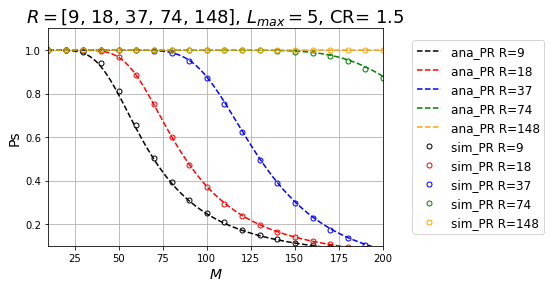

In [297]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.plot(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

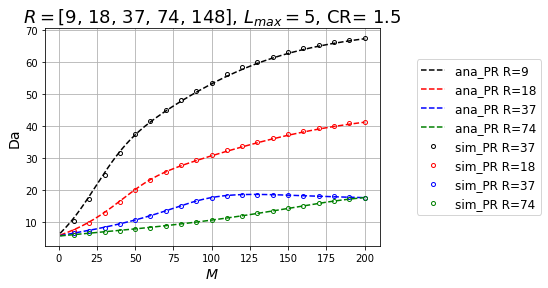

In [298]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.plot(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
# plt.plot(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
# plt.plot(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [299]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.plot(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# CR=3

In [337]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200
# sta_max = 500
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=3, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U

RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=1, 

RA_RU=74, sta_amount=7, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=7, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=7, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=7, capture_prob=0.0, i=2
RA_RU=74, sta_amount=7, capture_prob=0.0, i=2
RA_RU=74, sta_amount=7, capture_prob=0.0, i=2
RA_RU=74, sta_amount=7, capture_prob=0.0, i=2
RA_RU=74, sta_amount=7, capture_prob=0.0, i=2
RA_RU=74, sta_amount=7, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=7, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=7, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=7, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=7, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=7, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=7, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=7, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=7, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=7, capture_prob=0

RA_RU=74, sta_amount=12, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=12, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=12, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=12, capture_prob=0.0, i=2
RA_RU=74, sta_amount=12, capture_prob=0.0, i=2
RA_RU=74, sta_amount=12, capture_prob=0.0, i=2
RA_RU=74, sta_amount=12, capture_prob=0.0, i=2
RA_RU=74, sta_amount=12, capture_prob=0.0, i=2
RA_RU=74, sta_amount=12, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=12, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=12, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=12, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=12, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=12, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=12, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=12, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=12, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=

RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.7079457843841379, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.0, i=5
RA_RU=74, sta_amount=17, capture_prob=0.70794

RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amount=23, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=23, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=23, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=23, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=23, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=23, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amount=23, capture_prob=0.0, i=3
RA_RU=74, sta_amo

RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.7079457843841379, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=4
RA_RU=74, sta_amount=29, capture_prob=0.0, i=

RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.7079457843841379, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=4
RA_RU=74, sta_amount=34, capture_prob=0.0, i=

RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.7079457843841379, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=5
RA_RU=74, sta_amount=40, capture_prob=0.0, i=

RA_RU=74, sta_amount=47, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=47, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=47, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=47, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=47, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=47, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=47, capture_prob=0.0, i=2
RA_RU=74, sta_amount=47, capture_prob=0.0, i=2
RA_RU=74, sta_amount=47, capture_prob=0.0, i=2
RA_RU=74, sta_amount=47, capture_prob=0.0, i=2
RA_RU=74, sta_amount=47, capture_prob=0.0, i=2
RA_RU=74, sta_amount=47, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=47, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=47, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=47, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=47, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=47, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=

RA_RU=74, sta_amount=53, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=53, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=53, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=53, capture_prob=0.0, i=3
RA_RU=74, sta_amount=53, capture_prob=0.0, i=3
RA_RU=74, sta_amount=53, capture_prob=0.0, i=3
RA_RU=74, sta_amount=53, capture_prob=0.0, i=3
RA_RU=74, sta_amount=53, capture_prob=0.0, i=3
RA_RU=74, sta_amount=53, capture_prob=0.0, i=3
RA_RU=74, sta_amount=53, capture_prob=0.0, i=3
RA_RU=74, sta_amount=53, capture_prob=0.0, i=3
RA_RU=74, sta_amount=53, capture_prob=0.0, i=3
RA_RU=74, sta_amount=53, capture_prob=0.0, i=3
RA_RU=74, sta_amount=53, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=53, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=53, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=53, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=53, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=53, capture_p

RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.7079457843841379, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=4
RA_RU=74, sta_amount=59, capture_prob=0.0, i=

RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.7079457843841379, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=5
RA_RU=74, sta_amount=65, capture_prob=0.0, i=

RA_RU=74, sta_amount=72, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=72, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=72, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=72, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=72, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=72, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=72, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=72, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=72, capture_prob=0.0, i=2
RA_RU=74, sta_amount=72, capture_prob=0.0, i=2
RA_RU=74, sta_amount=72, capture_prob=0.0, i=2
RA_RU=74, sta_amount=72, capture_prob=0.0, i=2
RA_RU=74, sta_amount=72, capture_prob=0.0, i=2
RA_RU=74, sta_amount=72, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=72, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=72, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=72, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=

RA_RU=74, sta_amount=77, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=77, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=77, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=77, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=77, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=77, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=77, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=77, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=77, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=77, capture_prob=0.0, i=2
RA_RU=74, sta_amount=77, capture_prob=0.0, i=2
RA_RU=74, sta_amount=77, capture_prob=0.0, i=2
RA_RU=74, sta_amount=77, capture_prob=0.0, i=2
RA_RU=74, sta_amount=77, capture_prob=0.0, i=2
RA_RU=74, sta_amount=77, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=77, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=77, capture_prob=0.7079457843841379, i=2
RA_RU=74, sta_amount=

RA_RU=74, sta_amount=83, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=83, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=83, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=83, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=83, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=83, capture_prob=0.0, i=3
RA_RU=74, sta_amount=83, capture_prob=0.0, i=3
RA_RU=74, sta_amount=83, capture_prob=0.0, i=3
RA_RU=74, sta_amount=83, capture_prob=0.0, i=3
RA_RU=74, sta_amount=83, capture_prob=0.0, i=3
RA_RU=74, sta_amount=83, capture_prob=0.0, i=3
RA_RU=74, sta_amount=83, capture_prob=0.0, i=3
RA_RU=74, sta_amount=83, capture_prob=0.0, i=3
RA_RU=74, sta_amount=83, capture_prob=0.0, i=3
RA_RU=74, sta_amount=83, capture_prob=0.0, i=3
RA_RU=74, sta_amount=83, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=83, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=83, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=83, capture_p

RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.7079457843841379, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.7079457843841379, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, capture_prob=0.0, i=4
RA_RU=74, sta_amount=89, captu

RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.7079457843841379, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=5
RA_RU=74, sta_amount=95, capture_prob=0.0, i=

RA_RU=74, sta_amount=102, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=102, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=102, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=102, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=102, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=102, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=102, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=102, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=102, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=102, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=102, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=102, capture_prob=0.0, i=2
RA_RU=74, sta_amount=102, capture_prob=0.0, i=2
RA_RU=74, sta_amount=102, capture_prob=0.0, i=2
RA_RU=74, sta_amount=102, capture_prob=0.0, i=2
RA_RU=74, sta_amount=102, capture_prob=0.0, i=2
RA_RU=74, sta_amount=102, capture_prob=0.7079457843841379, i=2
RA_R

RA_RU=74, sta_amount=108, capture_prob=0.0, i=3
RA_RU=74, sta_amount=108, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=108, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=108, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=108, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=108, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=108, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=108, capture_prob=0.0, i=3
RA_RU=74, sta_amount=108, capture_prob=0.0, i=3
RA_RU=74, sta_amount=108, capture_prob=0.0, i=3
RA_RU=74, sta_amount=108, capture_prob=0.0, i=3
RA_RU=74, sta_amount=108, capture_prob=0.0, i=3
RA_RU=74, sta_amount=108, capture_prob=0.0, i=3
RA_RU=74, sta_amount=108, capture_prob=0.0, i=3
RA_RU=74, sta_amount=108, capture_prob=0.0, i=3
RA_RU=74, sta_amount=108, capture_prob=0.0, i=3
RA_RU=74, sta_amount=108, capture_prob=0.0, i=3
RA_RU=74, sta_amount=108, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=108, captu

RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.7079457843841379, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.0, i=4
RA_RU=74, sta_amount=114, capture_prob=0.7079457843841379, i=4
RA_RU=74, 

RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.7079457843841379, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120, capture_prob=0.0, i=5
RA_RU=74, sta_amount=120,

RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=127, capture_prob=0.0, i=2
RA_RU=74, sta_amount=127, capture_prob=0.0, i=2
RA_RU=74, sta_amount=127, capture_prob=0.0, i=2
RA_RU=74, sta_amount=127, capture_pro

RA_RU=74, sta_amount=133, capture_prob=0.0, i=3
RA_RU=74, sta_amount=133, capture_prob=0.0, i=3
RA_RU=74, sta_amount=133, capture_prob=0.0, i=3
RA_RU=74, sta_amount=133, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=133, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=133, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=133, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=133, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=133, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=133, capture_prob=0.0, i=3
RA_RU=74, sta_amount=133, capture_prob=0.0, i=3
RA_RU=74, sta_amount=133, capture_prob=0.0, i=3
RA_RU=74, sta_amount=133, capture_prob=0.0, i=3
RA_RU=74, sta_amount=133, capture_prob=0.0, i=3
RA_RU=74, sta_amount=133, capture_prob=0.0, i=3
RA_RU=74, sta_amount=133, capture_prob=0.0, i=3
RA_RU=74, sta_amount=133, capture_prob=0.0, i=3
RA_RU=74, sta_amount=133, capture_prob=0.0, i=3
RA_RU=74, sta_amount=133, capture_prob=0.0, i=

RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.7079457843841379, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139, capture_prob=0.0, i=4
RA_RU=74, sta_amount=139,

RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.7079457843841379, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.7079457843841379, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, sta_amount=145, capture_prob=0.0, i=5
RA_RU=74, 

RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=152, capture_prob=0.0, i=2
RA_RU=7

RA_RU=74, sta_amount=158, capture_prob=0.0, i=3
RA_RU=74, sta_amount=158, capture_prob=0.0, i=3
RA_RU=74, sta_amount=158, capture_prob=0.0, i=3
RA_RU=74, sta_amount=158, capture_prob=0.0, i=3
RA_RU=74, sta_amount=158, capture_prob=0.0, i=3
RA_RU=74, sta_amount=158, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=158, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=158, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=158, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=158, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=158, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=158, capture_prob=0.0, i=3
RA_RU=74, sta_amount=158, capture_prob=0.0, i=3
RA_RU=74, sta_amount=158, capture_prob=0.0, i=3
RA_RU=74, sta_amount=158, capture_prob=0.0, i=3
RA_RU=74, sta_amount=158, capture_prob=0.0, i=3
RA_RU=74, sta_amount=158, capture_prob=0.0, i=3
RA_RU=74, sta_amount=158, capture_prob=0.0, i=3
RA_RU=74, sta_amount=158, capture_prob=0.0, i=

RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.7079457843841379, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164, capture_prob=0.0, i=4
RA_RU=74, sta_amount=164,

RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.7079457843841379, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.0, i=5
RA_RU=74, sta_amount=170, capture_prob=0.7079457843841379, i=5
RA_RU=74, 

RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.7079457843841379, i=1
RA_RU=74, sta_amount=177, capture_prob=0.70794578438413

RA_RU=74, sta_amount=183, capture_prob=0.0, i=3
RA_RU=74, sta_amount=183, capture_prob=0.0, i=3
RA_RU=74, sta_amount=183, capture_prob=0.0, i=3
RA_RU=74, sta_amount=183, capture_prob=0.0, i=3
RA_RU=74, sta_amount=183, capture_prob=0.0, i=3
RA_RU=74, sta_amount=183, capture_prob=0.0, i=3
RA_RU=74, sta_amount=183, capture_prob=0.0, i=3
RA_RU=74, sta_amount=183, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=183, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=183, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=183, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=183, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=183, capture_prob=0.7079457843841379, i=3
RA_RU=74, sta_amount=183, capture_prob=0.0, i=3
RA_RU=74, sta_amount=183, capture_prob=0.0, i=3
RA_RU=74, sta_amount=183, capture_prob=0.0, i=3
RA_RU=74, sta_amount=183, capture_prob=0.0, i=3
RA_RU=74, sta_amount=183, capture_prob=0.0, i=3
RA_RU=74, sta_amount=183, capture_prob=0.0, i=

RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.7079457843841379, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189, capture_prob=0.0, i=4
RA_RU=74, sta_amount=189,

RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.7079457843841379, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195, capture_prob=0.0, i=5
RA_RU=74, sta_amount=195,

In [301]:
# Simulation (old -> m=200)

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9 = [1.0, 0.9993500000000001, 0.9855333333333323, 0.9101500000000017, 0.7709599999999998, 0.6034999999999997, 0.46969999999999873, 0.36356249999999996, 0.2884222222222216, 0.23142999999999983, 0.1917454545454549, 0.16180833333333391, 0.13984615384615431, 0.120835714285714, 0.10818000000000011, 0.0971562500000002, 0.08685294117647097, 0.0801555555555558, 0.0740315789473684, 0.0685650000000001]
da_list_simu_9 = [11.039658000000042, 18.208419094736946, 26.020689747515434, 32.79585777615615, 38.10799067996499, 42.15695701410337, 45.6421276194157, 48.696904030086436, 51.539684567495726, 54.38475632660759, 56.55592608353755, 58.69990997760061, 60.44575119176179, 62.102047103873204, 63.340857533937324, 64.433002239959, 65.42771085956916, 66.20018284083433, 67.04662851894366, 67.64633454950051]
t_list_simu_9 = [0.6666666666666636, 1.3324666666666605, 1.9710666666666645, 2.42706666666667, 2.569866666666665, 2.413999999999999, 2.191933333333335, 1.9390000000000012, 1.7305333333333308, 1.5428666666666677, 1.4061333333333337, 1.2944666666666713, 1.2120000000000044, 1.1278000000000035, 1.0818000000000025, 1.036333333333334, 0.9843333333333318, 0.9618666666666661, 0.9377333333333328, 0.9141999999999985]
u_list_simu_9 = [0.074074074074075, 0.14805185185185368, 0.21900740740741012, 0.26967407407407445, 0.2855407407407406, 0.2682222222222225, 0.24354814814814849, 0.21544444444444455, 0.19228148148148144, 0.17142962962962943, 0.15623703703703695, 0.14382962962962936, 0.13466666666666668, 0.12531111111111132, 0.12020000000000011, 0.11514814814814832, 0.10937037037037045, 0.1068740740740742, 0.10419259259259256, 0.10157777777777773]
power_list_simu_9 = [33.976, 169.297, 474.486, 861.944, 1159.946, 1270.212, 1293.559, 1254.379, 1209.126, 1159.111, 1112.374, 1074.447, 1045.158, 1008.123, 990.651, 969.677, 938.619, 930.438, 921.772, 908.085]

ps_list_simu_18 = [1.0, 1.0, 0.9992, 0.9904000000000032, 0.9483400000000063, 0.8438666666666673, 0.697728571428572, 0.5541875000000006, 0.4316111111111106, 0.3401899999999996, 0.2690909090909091, 0.2199749999999995, 0.18249230769230804, 0.15217142857142826, 0.12788000000000033, 0.11176875000000007, 0.09824117647058857, 0.08723888888888892, 0.07767894736842094, 0.07221]
da_list_simu_18 = [7.547359200000027, 10.223880600000028, 13.468433714532015, 17.25372363323688, 20.9162406534153, 23.866597473888692, 26.283824901998326, 28.14492201549011, 29.78334379649942, 31.2446823928629, 32.70471690805413, 34.1107948982341, 35.397752973228826, 36.603859277850944, 37.756982858551964, 38.71345069962551, 39.56892854397635, 40.30604297701551, 41.0920116614859, 41.54930454400233]
t_list_simu_18 = [1.25, 2.5, 3.747, 4.952, 5.927125, 6.329, 6.105125, 5.541875, 4.855625, 4.252375, 3.7, 3.299625, 2.9655, 2.663, 2.39775, 2.235375, 2.087625, 1.962875, 1.844875, 1.80525]
u_list_simu_18 = [0.06944444444444328, 0.13888888888888656, 0.2081666666666691, 0.27511111111110814, 0.32928472222222316, 0.35161111111111115, 0.33917361111111116, 0.30788194444444417, 0.26975694444444437, 0.23624305555555555, 0.20555555555555566, 0.18331249999999985, 0.16475000000000012, 0.14794444444444432, 0.13320833333333337, 0.1241875, 0.11597916666666695, 0.1090486111111113, 0.1024930555555556, 0.10029166666666689]
power_list_simu_18 = [17.52, 64.77, 168.662, 364.524, 623.263, 837.638, 947.941, 960.359, 918.493, 865.951, 806.968, 765.109, 725.156, 683.58, 643.196, 620.981, 598.271, 576.889, 556.757, 552.614]

ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 0.99984, 0.9986500000000005, 0.9921857142857129, 0.9672499999999994, 0.9062888888888888, 0.8078099999999995, 0.6800181818181823, 0.5504166666666664, 0.4339461538461501, 0.3382357142857146, 0.26080000000000003, 0.19915625000000023, 0.15240000000000037, 0.11674444444444441, 0.09104736842105257, 0.07018000000000008]
da_list_simu_37 = [6.5642283000000115, 7.541686200000038, 8.600268, 9.738980925000062, 11.075388444999996, 12.579160836984668, 14.18921185853221, 15.77579531351426, 16.9984768934431, 17.820969975826078, 18.311460982540556, 18.48513282756185, 18.453903512719787, 18.373770393321067, 18.231942422364718, 18.080742299670902, 17.909691627387488, 17.844603616215725, 17.745063926984106, 17.50867390745182]
t_list_simu_37 = [2.0, 4.0, 6.0, 8.0, 9.9984, 11.983800000000002, 13.89060000000002, 15.47599999999999, 16.31319999999999, 16.156199999999995, 14.960399999999982, 13.210000000000012, 11.28260000000002, 9.470600000000003, 7.824000000000002, 6.373000000000007, 5.181599999999998, 4.202799999999999, 3.4598, 2.807199999999999]
u_list_simu_37 = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.27022702702702256, 0.3238864864864853, 0.3754216216216237, 0.4182702702702715, 0.4408972972972974, 0.4366540540540535, 0.40433513513513497, 0.35702702702702643, 0.30493513513513515, 0.25596216216216244, 0.21145945945945946, 0.17224324324324272, 0.14004324324324333, 0.11358918918918898, 0.09350810810810789, 0.07587027027027021]
power_list_simu_37 = [13.252, 34.52, 67.372, 116.776, 193.016, 306.765, 460.235, 638.828, 781.022, 847.519, 827.054, 743.842, 635.393, 528.269, 431.332, 346.151, 276.984, 223.28, 181.915, 144.616]

ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999750000000001, 0.9999777777777777, 0.9998500000000001, 0.999636363636364, 0.9990083333333339, 0.9971384615384609, 0.9925857142857106, 0.9839333333333411, 0.967443749999999, 0.9417411764705894, 0.906355555555555, 0.8609157894736842, 0.8063100000000005]
da_list_simu_74 = [6.088830899999945, 6.596564400000012, 7.059670299999988, 7.577284275000042, 8.0755155, 8.649717650000023, 9.210682799999995, 9.825652364423153, 10.448978363636364, 11.140107627637624, 11.835903513987233, 12.613168308596686, 13.416710247224804, 14.201075907667287, 15.002930729386492, 15.752828861795873, 16.44168053374139, 16.973443270228653, 17.471825925291476, 17.84230576645428]
t_list_simu_74 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 15.999600000000001, 17.999599999999997, 19.996999999999996, 21.992, 23.97619999999998, 25.92559999999995, 27.792399999999915, 29.517999999999926, 30.95819999999997, 32.01920000000002, 32.628800000000034, 32.71479999999999, 32.252400000000016]
u_list_simu_74 = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.2162108108108128, 0.2432378378378435, 0.2702297297297254, 0.2971891891891846, 0.32400270270270154, 0.3503459459459489, 0.37557297297297376, 0.3988918918918928, 0.41835405405405446, 0.4326918918918915, 0.44092972972972955, 0.442091891891892, 0.435843243243243]
power_list_simu_74 = [11.466, 26.716, 45.528, 69.676, 98.796, 136.16, 180.77, 236.978, 304.728, 391.241, 490.828, 617.055, 764.498, 924.724, 1101.864, 1277.151, 1438.346, 1560.452, 1654.912, 1697.288]

ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999764705882354, 0.9999666666666667, 0.9999789473684211, 0.99997]
da_list_simu_148 = [5.8925450999999125, 6.143575349999996, 6.37172449999999, 6.626631300000022, 6.84118416000002, 7.1041088000000014, 7.331785199999995, 7.579908037500035, 7.845254733333348, 8.093555639999998, 8.38974812727273, 8.650474049999985, 8.919526984615382, 9.20902142142858, 9.498417359999998, 9.821310337500046, 10.104393236134461, 10.442207527715354, 10.790602182698768, 11.114328262833894]
t_list_simu_148 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 33.999199999999995, 35.998799999999996, 37.999199999999995, 39.998799999999996]
u_list_simu_148 = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972432432432763, 0.24323513513514078, 0.25675135135134536, 0.2702621621621577]
power_list_simu_148 = [10.774, 23.356, 37.52, 53.88, 71.48, 92.274, 114.388, 139.302, 167.626, 198.318, 234.3, 272.004, 314.11, 361.8, 413.232, 474.286, 535.712, 609.146, 691.44, 776.866]

In [302]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.plot(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

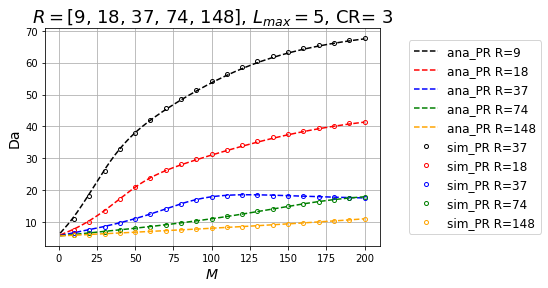

In [303]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.plot(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [304]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.plot(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# CR=6

In [339]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200

m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]


for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=6, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U

In [340]:
# Simulation (old -> m=200)
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9 = [1.0, 0.9978000000000005, 0.9679666666666643, 0.8601999999999999, 0.6998999999999999, 0.5352666666666672, 0.40982857142856943, 0.3156000000000003, 0.25258888888888903, 0.20519999999999924, 0.16868181818181824, 0.14354166666666723, 0.12326153846153867, 0.10803571428571428, 0.09585333333333367, 0.0874375, 0.07829411764705928, 0.07210000000000019, 0.06573157894736845, 0.06154000000000001]
da_list_simu_9 = [11.76693660000005, 19.757869758101254, 27.959320430769143, 34.594537993156735, 39.639264173531636, 43.576721314769834, 46.8708246717395, 49.81710045584017, 52.464816471911355, 55.3074405695989, 57.55504267561214, 59.580695953875434, 61.26496966351286, 62.653893024144594, 64.14150298870616, 65.08765278946943, 65.99740357320906, 66.85075266057329, 67.63914508044378, 67.9660483587786]
t_list_simu_9 = [0.6666666666666636, 1.3303999999999947, 1.9359333333333286, 2.293866666666672, 2.333, 2.141066666666669, 1.9125333333333332, 1.6831999999999945, 1.5155333333333336, 1.3680000000000017, 1.2370000000000025, 1.1483333333333379, 1.0682666666666676, 1.008333333333333, 0.958533333333333, 0.9326666666666646, 0.8873333333333314, 0.8651999999999997, 0.8325999999999996, 0.8205333333333324]
u_list_simu_9 = [0.074074074074075, 0.14782222222222396, 0.2151037037037052, 0.2548740740740745, 0.2592222222222225, 0.23789629629629686, 0.2125037037037037, 0.18702222222222192, 0.1683925925925923, 0.15199999999999997, 0.1374444444444444, 0.12759259259259267, 0.11869629629629638, 0.11203703703703717, 0.10650370370370388, 0.1036296296296297, 0.09859259259259268, 0.09613333333333332, 0.09251111111111106, 0.09117037037037026]
power_list_simu_9 = [38.438, 197.352, 529.487, 891.964, 1118.943, 1182.248, 1170.672, 1123.0, 1085.667, 1051.168, 1001.073, 972.063, 936.772, 910.515, 892.286, 882.484, 854.886, 847.142, 825.567, 819.98]


ps_list_simu_18 = [0.9999, 0.9998, 0.9977, 0.9787250000000035, 0.8999000000000015, 0.7654500000000004, 0.6078000000000019, 0.47685000000000016, 0.3673333333333323, 0.29348000000000024, 0.2327272727272731, 0.18951666666666656, 0.15873076923076987, 0.13179285714285735, 0.11239333333333366, 0.09938749999999995, 0.08731764705882404, 0.0780666666666669, 0.07074736842105254, 0.06398499999999997]
da_list_simu_18 = [7.8552770333333655, 10.808866426315827, 14.704217791735058, 18.56819356671399, 22.250049277531662, 24.912725412567085, 27.07227339833362, 28.79093349739267, 30.409382606901595, 31.96106462519609, 33.345694068615856, 34.672089440348955, 35.90753505308134, 37.16002035799044, 38.190422163089565, 39.1004612615002, 39.989667965017766, 40.744198445663166, 41.25179988803785, 41.90282136588307]
t_list_simu_18 = [1.249875, 2.4995, 3.741375, 4.893625, 5.624375, 5.740875, 5.31825, 4.7685, 4.1325, 3.6685, 3.2, 2.84275, 2.579375, 2.306375, 2.107375, 1.98775, 1.8555, 1.7565, 1.68025, 1.599625]
u_list_simu_18 = [0.06943749999999883, 0.13886111111110877, 0.20785416666666898, 0.2718680555555537, 0.3124652777777776, 0.31893749999999993, 0.29545833333333316, 0.26491666666666674, 0.22958333333333314, 0.20380555555555563, 0.17777777777777745, 0.15793055555555546, 0.14329861111111108, 0.1281319444444443, 0.11707638888888888, 0.11043055555555575, 0.10308333333333347, 0.09758333333333341, 0.09334722222222226, 0.08886805555555548]
power_list_simu_18 = [18.983, 72.846, 203.279, 415.381, 661.643, 818.427, 868.232, 856.28, 807.978, 772.944, 717.868, 675.022, 643.785, 605.037, 575.069, 560.106, 539.252, 523.406, 509.462, 495.271]


ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 0.9993400000000003, 0.9949666666666672, 0.9754142857142847, 0.9181624999999999, 0.8208111111111104, 0.6954, 0.5607545454545445, 0.44656666666666617, 0.34670000000000073, 0.2678714285714284, 0.20452000000000012, 0.15684374999999995, 0.12113529411764759, 0.0935999999999999, 0.07187894736842088, 0.055099999999999906]
da_list_simu_37 = [6.652727100000004, 7.7898799500000395, 8.963718200000002, 10.35563602500007, 11.857046030306126, 13.523290868770678, 15.226590320945714, 16.577687868369836, 17.528645382097544, 18.031236339078422, 18.254625063611368, 18.323849174314308, 18.237963759516564, 18.101225520832763, 18.02828932319914, 17.827308206062703, 17.740248201407514, 17.774290185956847, 17.41306677147843, 17.36388988375906]
t_list_simu_37 = [2.0, 4.0, 6.0, 8.0, 9.993400000000003, 11.939600000000024, 13.65580000000005, 14.690599999999998, 14.774599999999984, 13.908000000000007, 12.336600000000011, 10.717600000000012, 9.014199999999992, 7.5004000000000035, 6.135599999999998, 5.018999999999998, 4.118600000000001, 3.3695999999999975, 2.731399999999997, 2.204]
u_list_simu_37 = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.2700918918918875, 0.32269189189189096, 0.3690756756756764, 0.3970432432432435, 0.3993135135135134, 0.37589189189189126, 0.33342162162162137, 0.28966486486486465, 0.24362702702702707, 0.20271351351351347, 0.16582702702702712, 0.13564864864864873, 0.11131351351351351, 0.09107027027027013, 0.07382162162162165, 0.059567567567567876]
power_list_simu_37 = [13.616, 37.024, 73.922, 133.822, 225.951, 359.524, 527.943, 672.979, 753.381, 748.356, 679.689, 595.068, 496.931, 408.712, 331.232, 266.355, 216.395, 178.276, 139.197, 111.716]


ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.9999666666666667, 1.0, 0.9999750000000001, 0.9998666666666666, 0.9997100000000002, 0.9985272727272736, 0.995641666666669, 0.9889230769230747, 0.9767999999999969, 0.9546266666666733, 0.9204499999999995, 0.874441176470586, 0.8216944444444451, 0.7610157894736841, 0.6943150000000005]
da_list_simu_74 = [6.204560099999953, 6.724206900000014, 7.25746889999999, 7.840653300000053, 8.418732000000002, 9.034572013793126, 9.677813828571422, 10.328592906730844, 11.086490334090906, 11.90267739813236, 12.715862189036628, 13.57661065997598, 14.432922340118873, 15.264342731410522, 15.970388773066677, 16.617285627510427, 17.11940876228246, 17.547239409917722, 17.807699264419867, 18.04414469233788]
t_list_simu_74 = [2.0, 4.0, 6.0, 8.0, 10.0, 11.999600000000001, 14.0, 15.999600000000001, 17.997600000000002, 19.9942, 21.967599999999994, 23.895399999999952, 25.711999999999954, 27.350399999999958, 28.638800000000007, 29.454399999999985, 29.730999999999966, 29.580999999999957, 28.918600000000016, 27.772599999999994]
u_list_simu_74 = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16215675675675603, 0.1891891891891912, 0.2162108108108128, 0.24321081081081647, 0.2701918918918877, 0.2968594594594551, 0.3229108108108099, 0.34745945945946144, 0.36959999999999904, 0.38701081081081007, 0.39803243243243214, 0.40177027027026907, 0.3997432432432428, 0.390791891891891, 0.37530540540540486]
power_list_simu_74 = [11.932, 27.672, 48.018, 74.436, 107.882, 149.082, 201.794, 265.418, 349.792, 454.865, 578.658, 725.561, 889.926, 1062.378, 1218.662, 1355.94, 1449.639, 1512.411, 1521.011, 1497.525]


ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99995625, 0.9999764705882354, 0.9998944444444448, 0.9998263157894739, 0.9996250000000003]
da_list_simu_148 = [5.940198299999915, 6.228670349999987, 6.473082099999988, 6.7480335000000276, 7.036335360000003, 7.340294700000005, 7.572806657142848, 7.868521912500035, 8.140313766666656, 8.41680318, 8.76767307272725, 9.057133600000004, 9.383840215384602, 9.695967428571416, 10.034553680000002, 10.394409199612042, 10.77236316365547, 11.119590460796584, 11.487328925564896, 11.926361362950605]
t_list_simu_148 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 31.9986, 33.999199999999995, 35.996199999999995, 37.993399999999994, 39.984999999999985]
u_list_simu_148 = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.2162067567567587, 0.22972432432432763, 0.24321756756757315, 0.25671216216215625, 0.27016891891891465]
power_list_simu_148 = [10.95, 23.988, 38.724, 55.76, 75.572, 98.334, 121.828, 150.042, 180.704, 215.008, 256.766, 300.528, 350.398, 404.318, 467.736, 538.789, 619.64, 704.017, 797.837, 914.723]

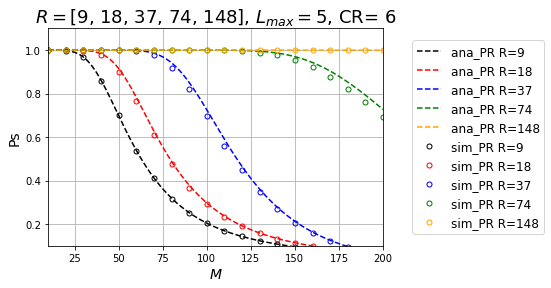

In [341]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.plot(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

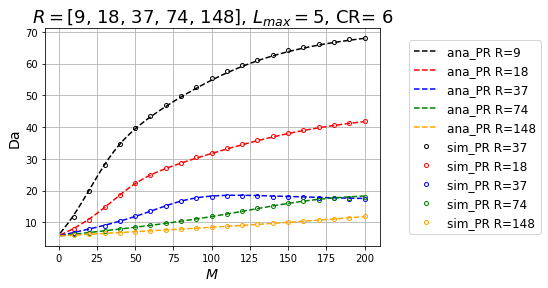

In [342]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.plot(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

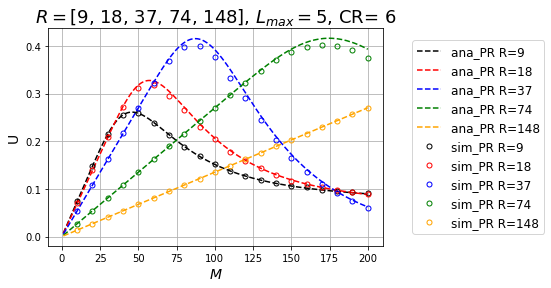

In [343]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.plot(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()